In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LassoCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

import optuna
from optuna.integration import OptunaSearchCV

In [2]:
# Load environment variables
load_dotenv()

train_mmse = os.environ.get("TRAIN_MMSE")

train = os.path.join(os.environ.get("TRAIN"), 'adresso-features-train.csv')
train_augmented = os.path.join(os.environ.get("TRAIN"), 'adresso-features-augmented-train.csv')
test = os.path.join(os.environ.get("TEST"), 'adresso-features-test.csv')

train_openl3 = os.path.join(os.environ.get("TRAIN"), 'adresso-openl3-pca-embeddings-train.csv')
test_openl3 = os.path.join(os.environ.get("TEST"), 'adresso-openl3-pca-embeddings-test.csv')

truth_task1 = os.path.join(os.environ.get("TRUTH_TASK1"))

### Reading Acoustic Data

In [30]:
# features_df = pd.read_csv(features)
# dx_df = pd.read_csv(train_mmse, usecols=['adressfname', 'dx', 'mmse'])

# # merging the two dataframes on adressfname
# df = pd.merge(features_df, dx_df, on='adressfname')
# df.to_csv(os.path.join(os.environ.get("TRAIN"), 'adresso-features-train.csv'), index=False)

In [3]:
df = pd.read_csv(train)
df.head()

,MFCCs_mean,MFCCs_std,MFCCs_min,MFCCs_max,MFCCs_Q1,MFCCs_Q2,MFCCs_Q3,MFCCs_d1_mean,MFCCs_d1_std,MFCCs_d1_min,...,RMS_Energy_Q3,SNR,Pitch,Duration,HNR_mean,HNR_std,HNR_max,adressfname,dx,mmse
0,-20.392339,123.700237,-557.285820,247.689651,-12.589321,-0.933948,13.461918,0.012523,4.187519,-41.328216,...,0.039488,37650.060927,60.659047,224.206916,-165.855528,77.315477,27.117794,adrso024,ad,20
1,-27.227270,143.403495,-702.302502,241.789555,-7.330947,1.563355,12.549985,0.014154,2.828714,-30.478220,...,0.007299,6707.629520,38.316251,170.779977,-186.915390,50.495271,23.753750,adrso025,ad,11
2,-19.190823,120.809974,-713.867854,216.206818,-10.479501,5.762882,22.069600,0.016527,2.615273,-41.517980,...,0.006945,2874.613576,31.260772,69.915873,-176.800520,65.050773,27.822335,adrso027,ad,18
3,-26.171295,147.473792,-728.981896,211.866351,-6.662497,2.935268,18.348571,0.047427,2.115747,-14.495990,...,0.004108,2882.739511,46.486516,52.148912,-196.003998,28.588117,31.310324,adrso028,ad,18
4,-24.511270,122.793868,-599.425992,223.091272,-6.075605,2.094260,14.738329,0.013892,2.622402,-37.899971,...,0.007457,12348.669892,97.143278,54.506893,-190.825256,43.328165,28.061867,adrso031,ad,26


In [4]:
test_df = pd.read_csv(test)
test_df.head()

,MFCCs_mean,MFCCs_std,MFCCs_min,MFCCs_max,MFCCs_Q1,MFCCs_Q2,MFCCs_Q3,MFCCs_d1_mean,MFCCs_d1_std,MFCCs_d1_min,...,RMS_Energy_Q1,RMS_Energy_Q2,RMS_Energy_Q3,SNR,Pitch,Duration,HNR_mean,HNR_std,HNR_max,adressfname
0,-23.879873,131.128569,-537.000015,240.187874,-3.831189,3.159696,10.574533,0.035797,5.871200,-33.539985,...,0.000306,0.003991,0.052062,1.031803e+06,85.753026,58.327959,-145.944542,93.404086,33.843171,adrsdt1
1,-22.916366,114.285416,-519.128245,216.476958,-13.047467,1.853330,13.223973,0.016850,5.450128,-40.721839,...,0.000857,0.018102,0.053067,2.029699e+05,119.694230,46.677914,-140.492581,95.104062,32.589739,adrsdt10
2,-19.238629,116.446145,-520.264291,240.262613,-14.222423,-0.461745,9.374266,0.004707,6.063852,-42.140066,...,0.003033,0.059429,0.107949,2.516352e+06,114.396639,62.832925,-94.553701,105.915648,30.725673,adrsdt11
3,-23.374392,125.694430,-547.389531,231.887660,-13.363540,0.371793,5.625976,-0.001700,5.809461,-43.575232,...,0.000669,0.051530,0.104460,3.640965e+06,140.411818,72.848912,-93.449538,109.587233,36.046877,adrsdt12
4,-21.564015,111.063830,-526.444365,237.651498,-14.790231,-0.537706,9.264870,0.001318,5.489112,-52.197976,...,0.001983,0.013169,0.107892,2.778914e+06,116.897670,29.613946,-116.455011,103.176791,29.393578,adrsdt13


In [5]:
ground_truth_df = pd.read_csv(truth_task1)
ground_truth_df.head()

,ID,Dx
0,adrsdt15,Control
1,adrsdt40,Control
2,adrsdt26,Control
3,adrsdt67,Control
4,adrsdt58,Control


#### Data Cleaning

In [6]:
# Removing inf values from SNR
snr = df['SNR']
snr_without_inf = snr[snr != float('inf')]
snr[snr == float('inf')] = np.sort(snr_without_inf)[-1]

df['SNR'] = snr

In [51]:
augmented_df = pd.read_csv(train_augmented)

# Removing inf values from SNR
snr = augmented_df['SNR']
snr_without_inf = snr[snr != float('inf')]
snr[snr == float('inf')] = np.sort(snr_without_inf)[-1]

augmented_df['SNR'] = snr

In [7]:
# Removing inf values from SNR
snr = test_df['SNR']
snr_without_inf = snr[snr != float('inf')]
snr[snr == float('inf')] = np.sort(snr_without_inf)[-1]

test_df['SNR'] = snr

In [8]:
# Map values in 'Dx' column to 'cn' and 'ad' -> TESTING Purposes
ground_truth_df['Dx'] = ground_truth_df['Dx'].map({'Control': 'cn', 'ProbableAD': 'ad'})

In [9]:
# Merging the test features with the ground truth
test_df = pd.merge(test_df, ground_truth_df, left_on='adressfname', right_on='ID')

#### Model Building

In [46]:
# Features and categorical target variable
X = df.drop(['adressfname', 'dx', 'mmse'], axis=1)
y = df['dx']

X_test = test_df.drop(['adressfname', 'Dx', 'ID'], axis=1)

In [47]:
# Label encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Define the Logistic Regression model
lr = LogisticRegression()

# Parameter distribution
param_distribution = {
    "C": optuna.distributions.FloatDistribution(1e-3, 1e3)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(lr, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_scaled, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Logistic Regression: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Logistic Regression: {optuna_search.best_score_:.4f}")

[I 2024-03-10 03:21:59,231] A new study created in memory with name: no-name-d266cbc9-250e-4dfc-910f-cf9dc57c366d
[I 2024-03-10 03:21:59,427] Trial 0 finished with value: 0.5655971479500892 and parameters: {'C': 891.0673059726297}. Best is trial 0 with value: 0.5655971479500892.
[I 2024-03-10 03:21:59,605] Trial 1 finished with value: 0.5654188948306595 and parameters: {'C': 603.4376790748237}. Best is trial 0 with value: 0.5655971479500892.


[I 2024-03-10 03:21:59,781] Trial 2 finished with value: 0.5775401069518716 and parameters: {'C': 901.7908036880772}. Best is trial 2 with value: 0.5775401069518716.
[I 2024-03-10 03:22:00,041] Trial 3 finished with value: 0.5657754010695186 and parameters: {'C': 523.2870322793327}. Best is trial 2 with value: 0.5775401069518716.
[I 2024-03-10 03:22:00,202] Trial 4 finished with value: 0.5654188948306595 and parameters: {'C': 248.21073902154288}. Best is trial 2 with value: 0.5775401069518716.
[I 2024-03-10 03:22:00,345] Trial 5 finished with value: 0.5655971479500892 and parameters: {'C': 551.0455390111865}. Best is trial 2 with value: 0.5775401069518716.
[I 2024-03-10 03:22:00,501] Trial 6 finished with value: 0.5957219251336898 and parameters: {'C': 113.43747024073201}. Best is trial 6 with value: 0.5957219251336898.
[I 2024-03-10 03:22:00,595] Trial 7 finished with value: 0.5896613190730837 and parameters: {'C': 112.40796624401081}. Best is trial 6 with value: 0.5957219251336898.
[

Best Parameters for Logistic Regression: {'C': 2.1130427192731425}
Best Mean Accuracy for Logistic Regression: 0.6383


In [44]:
# Define the Random Forest model
model = RandomForestClassifier()

# Parameter distribution
param_distribution = {
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "max_depth": optuna.distributions.IntDistribution(5, 15),
    "min_samples_split": optuna.distributions.IntDistribution(2, 10),
    "min_samples_leaf": optuna.distributions.IntDistribution(1, 4)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_scaled, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Random Forest: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Random Forest: {optuna_search.best_score_:.4f}")

[I 2024-03-10 03:22:40,734] A new study created in memory with name: no-name-ecc74d54-ca0e-4c70-abd1-ec7d9db36de4
[I 2024-03-10 03:22:43,137] Trial 0 finished with value: 0.5957219251336898 and parameters: {'n_estimators': 160, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5957219251336898.
[I 2024-03-10 03:22:50,790] Trial 1 finished with value: 0.571301247771836 and parameters: {'n_estimators': 483, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5957219251336898.
[I 2024-03-10 03:22:57,129] Trial 2 finished with value: 0.5836007130124777 and parameters: {'n_estimators': 428, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5957219251336898.
[I 2024-03-10 03:23:01,356] Trial 3 finished with value: 0.5773618538324421 and parameters: {'n_estimators': 331, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0

Best Parameters for Random Forest: {'n_estimators': 165, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best Mean Accuracy for Random Forest: 0.6378


In [45]:
# Define the XGBClassifier model
model = XGBClassifier()

# Parameter distribution
param_distribution = {
    "booster": optuna.distributions.CategoricalDistribution(['gbtree', 'gblinear']),
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]),
    "max_depth": optuna.distributions.IntDistribution(3, 9)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_scaled, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for XGBClassifier: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for XGBClassifier: {optuna_search.best_score_:.4f}")

[I 2024-03-10 03:54:55,584] A new study created in memory with name: no-name-5f71b1e2-cebf-4bf5-88b2-92f6696ed91e


[I 2024-03-10 03:54:56,130] Trial 0 finished with value: 0.6381461675579323 and parameters: {'booster': 'gblinear', 'n_estimators': 362, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 0 with value: 0.6381461675579323.
[I 2024-03-10 03:54:56,635] Trial 1 finished with value: 0.6320855614973262 and parameters: {'booster': 'gblinear', 'n_estimators': 460, 'learning_rate': 0.05, 'max_depth': 4}. Best is trial 0 with value: 0.6381461675579323.
[I 2024-03-10 03:54:59,892] Trial 2 finished with value: 0.5959001782531195 and parameters: {'booster': 'gbtree', 'n_estimators': 305, 'learning_rate': 0.001, 'max_depth': 9}. Best is trial 0 with value: 0.6381461675579323.
[I 2024-03-10 03:55:00,141] Trial 3 finished with value: 0.5122994652406417 and parameters: {'booster': 'gblinear', 'n_estimators': 111, 'learning_rate': 0.001, 'max_depth': 3}. Best is trial 0 with value: 0.6381461675579323.
[I 2024-03-10 03:55:00,313] Trial 4 finished with value: 0.5180035650623885 and parameters: {'booster

Best Parameters for XGBClassifier: {'booster': 'gblinear', 'n_estimators': 353, 'learning_rate': 0.05, 'max_depth': 7}
Best Mean Accuracy for XGBClassifier: 0.6504


In [51]:
# Define the LGBMClassifier model
model = LGBMClassifier(verbose=-1)

# Parameter distribution
param_distribution = {
    "boosting_type": optuna.distributions.CategoricalDistribution(['gbdt', 'dart']),
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]),
    "max_depth": optuna.distributions.IntDistribution(3, 9)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_scaled, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for LightGBM: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for LightGBM: {optuna_search.best_score_:.4f}")


[I 2024-03-10 08:43:05,753] A new study created in memory with name: no-name-03a8733e-4fca-4caf-850d-3cc8a4c46221
[I 2024-03-10 08:43:06,690] Trial 0 finished with value: 0.5237076648841354 and parameters: {'boosting_type': 'dart', 'n_estimators': 294, 'learning_rate': 0.01, 'max_depth': 5}. Best is trial 0 with value: 0.5237076648841354.
[I 2024-03-10 08:43:07,654] Trial 1 finished with value: 0.5413547237076648 and parameters: {'boosting_type': 'dart', 'n_estimators': 348, 'learning_rate': 0.001, 'max_depth': 8}. Best is trial 1 with value: 0.5413547237076648.
[I 2024-03-10 08:43:08,469] Trial 2 finished with value: 0.5657754010695186 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 282, 'learning_rate': 0.02, 'max_depth': 4}. Best is trial 2 with value: 0.5657754010695186.
[I 2024-03-10 08:43:09,303] Trial 3 finished with value: 0.584313725490196 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 391, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 3 with value

Best Parameters for LightGBM: {'boosting_type': 'gbdt', 'n_estimators': 288, 'learning_rate': 0.02, 'max_depth': 8}
Best Mean Accuracy for LightGBM: 0.5963


In [47]:
# Define the DecisionTreeClassifier model
model = DecisionTreeClassifier()

# Parameter distribution
param_distribution = {
    "max_depth": optuna.distributions.IntDistribution(3, 9),
    "min_samples_split": optuna.distributions.IntDistribution(2, 10)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_scaled, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Decision Tree: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Decision Tree: {optuna_search.best_score_:.4f}")


[I 2024-03-10 04:03:21,607] A new study created in memory with name: no-name-40f7c576-d12f-4d62-b70a-d51765ef4ecd
[I 2024-03-10 04:03:21,681] Trial 0 finished with value: 0.5775401069518716 and parameters: {'max_depth': 9, 'min_samples_split': 3}. Best is trial 0 with value: 0.5775401069518716.
[I 2024-03-10 04:03:21,749] Trial 1 finished with value: 0.5959001782531195 and parameters: {'max_depth': 6, 'min_samples_split': 10}. Best is trial 1 with value: 0.5959001782531195.
[I 2024-03-10 04:03:21,834] Trial 2 finished with value: 0.5894830659536543 and parameters: {'max_depth': 6, 'min_samples_split': 4}. Best is trial 1 with value: 0.5959001782531195.
[I 2024-03-10 04:03:21,893] Trial 3 finished with value: 0.5775401069518716 and parameters: {'max_depth': 9, 'min_samples_split': 8}. Best is trial 1 with value: 0.5959001782531195.
[I 2024-03-10 04:03:21,940] Trial 4 finished with value: 0.5119429590017825 and parameters: {'max_depth': 3, 'min_samples_split': 6}. Best is trial 1 with va

Best Parameters for Decision Tree: {'max_depth': 7, 'min_samples_split': 7}
Best Mean Accuracy for Decision Tree: 0.6380


In [48]:
# Define the SVC model
model = SVC()

# Parameter distribution
param_distribution = {
    "C": optuna.distributions.FloatDistribution(1e-3, 1e3),
    "kernel": optuna.distributions.CategoricalDistribution(['linear', 'rbf'])
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_scaled, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for SVM: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for SVM: {optuna_search.best_score_:.4f}")

[I 2024-03-10 04:03:56,871] A new study created in memory with name: no-name-ca8c31c4-4721-436d-b9de-7831ee4d9684
[I 2024-03-10 04:03:56,906] Trial 0 finished with value: 0.5834224598930481 and parameters: {'C': 537.2466365129662, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5834224598930481.
[I 2024-03-10 04:03:56,930] Trial 1 finished with value: 0.5834224598930481 and parameters: {'C': 555.17293107522, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5834224598930481.
[I 2024-03-10 04:04:06,143] Trial 2 finished with value: 0.6253119429590017 and parameters: {'C': 327.38963559876214, 'kernel': 'linear'}. Best is trial 2 with value: 0.6253119429590017.
[I 2024-03-10 04:04:09,801] Trial 3 finished with value: 0.6194295900178253 and parameters: {'C': 178.22770407835046, 'kernel': 'linear'}. Best is trial 2 with value: 0.6253119429590017.
[I 2024-03-10 04:04:09,848] Trial 4 finished with value: 0.5834224598930481 and parameters: {'C': 531.2113461744688, 'kernel': 'rbf'}. Best is trial

Best Parameters for SVM: {'C': 4.998866935092116, 'kernel': 'linear'}
Best Mean Accuracy for SVM: 0.6435


In [49]:
# Define the AdaBoostClassifier model
model = AdaBoostClassifier()

# Parameter distribution
param_distribution = {
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1])
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_scaled, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for AdaBoostClassifier: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for AdaBoostClassifier: {optuna_search.best_score_:.4f}")


[I 2024-03-10 05:15:06,620] A new study created in memory with name: no-name-2ce29609-0746-4c40-8dc6-4d702bdcc3bd
[I 2024-03-10 05:15:16,249] Trial 0 finished with value: 0.4579322638146167 and parameters: {'n_estimators': 316, 'learning_rate': 0.002}. Best is trial 0 with value: 0.4579322638146167.
[I 2024-03-10 05:15:21,749] Trial 1 finished with value: 0.517825311942959 and parameters: {'n_estimators': 179, 'learning_rate': 0.02}. Best is trial 1 with value: 0.517825311942959.
[I 2024-03-10 05:15:31,704] Trial 2 finished with value: 0.5301247771836006 and parameters: {'n_estimators': 394, 'learning_rate': 0.1}. Best is trial 2 with value: 0.5301247771836006.
[I 2024-03-10 05:15:41,066] Trial 3 finished with value: 0.5060606060606061 and parameters: {'n_estimators': 354, 'learning_rate': 0.02}. Best is trial 2 with value: 0.5301247771836006.
[I 2024-03-10 05:15:52,709] Trial 4 finished with value: 0.5242424242424242 and parameters: {'n_estimators': 440, 'learning_rate': 0.1}. Best is

Best Parameters for AdaBoostClassifier: {'n_estimators': 416, 'learning_rate': 0.05}
Best Mean Accuracy for AdaBoostClassifier: 0.5602


Testing hypertuned models that are trained on original acoustic dataset.

In [57]:
# Storing the best hypertuned parameters for logistic regression
lr_best_params = {'C': 2.1130427192731425}
best_lr = LogisticRegression(**lr_best_params)

# Storing the best hypertuned parameters for Random Forest
rf_best_params = {'n_estimators': 165, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1}
best_rf = RandomForestClassifier(**rf_best_params)

# Storing the best hypertuned parameters for XGBoost
xgb_best_params = {'booster': 'gblinear', 'n_estimators': 353, 'learning_rate': 0.05, 'max_depth': 7}
best_xgb = XGBClassifier(**xgb_best_params)

# Storing the best hypertuned parameters for LightGBM
lgbm_best_params = {'boosting_type': 'gbdt', 'n_estimators': 288, 'learning_rate': 0.02, 'max_depth': 8}
best_lgbm = LGBMClassifier(**lgbm_best_params, verbose=-1)

# Storing the best hypertuned parameters for Decision Tree
dt_best_params = {'max_depth': 7, 'min_samples_split': 7}
best_dt = DecisionTreeClassifier(**dt_best_params)

# Storing the best hypertuned parameters for SVM
svm_best_params = {'C': 4.998866935092116, 'kernel': 'linear'}
best_svm = SVC(**svm_best_params)

# Storing the best hypertuned parameters for AdaBoost
ada_best_params = {'n_estimators': 416, 'learning_rate': 0.05}
best_ada = AdaBoostClassifier(**ada_best_params)

In [58]:
# Training all the models with best parameters
best_lr.fit(X_scaled, y_encoded)
best_rf.fit(X_scaled, y_encoded)
best_xgb.fit(X_scaled, y_encoded)
best_lgbm.fit(X_scaled, y_encoded)
best_dt.fit(X_scaled, y_encoded)
best_svm.fit(X_scaled, y_encoded)
best_ada.fit(X_scaled, y_encoded)

print("All hypertuned models trained")

All hypertuned models trained


In [59]:
# Testing the models on the test data
predictions = best_lr.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
total_samples = len(test_df)
accuracy = correct_predictions / total_samples

print(f'Accuracy of Logistic Regression: {accuracy:.4f}')

predictions = best_rf.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Random Forest: {accuracy:.4f}')

predictions = best_xgb.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of XGBoost: {accuracy:.4f}')

predictions = best_lgbm.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of LightGBM: {accuracy:.4f}')

predictions = best_dt.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Decision Tree: {accuracy:.4f}')

predictions = best_svm.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of SVM: {accuracy:.4f}')

predictions = best_ada.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of AdaBoost: {accuracy:.4f}')

Accuracy of Logistic Regression: 0.6338
Accuracy of Random Forest: 0.6197
Accuracy of XGBoost: 0.6620
Accuracy of LightGBM: 0.6056
Accuracy of Decision Tree: 0.5211
Accuracy of SVM: 0.6620
Accuracy of AdaBoost: 0.5493


Testing base models on original acoustic dataset.

In [48]:
# Define base models
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42, verbose=-1)
dt = DecisionTreeClassifier(random_state=42)
svm = SVC(random_state=42)
ada = AdaBoostClassifier(random_state=42)

In [49]:
# Train base models on original acoustic dataset
lr.fit(X_scaled, y_encoded)
rf.fit(X_scaled, y_encoded)
xgb.fit(X_scaled, y_encoded)
lgbm.fit(X_scaled, y_encoded)
dt.fit(X_scaled, y_encoded)
svm.fit(X_scaled, y_encoded)
ada.fit(X_scaled, y_encoded)

print('All base models trained')

All base models trained


In [50]:
# Testing the models on the test data
predictions = lr.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
total_samples = len(test_df)
accuracy = correct_predictions / total_samples

print(f'Accuracy of Logistic Regression: {accuracy:.4f}')

predictions = rf.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Random Forest: {accuracy:.4f}')

predictions = xgb.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of XGBoost: {accuracy:.4f}')

predictions = lgbm.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of LightGBM: {accuracy:.4f}')

predictions = dt.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Decision Tree: {accuracy:.4f}')

predictions = svm.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of SVM: {accuracy:.4f}')

predictions = ada.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of AdaBoost: {accuracy:.4f}')

Accuracy of Logistic Regression: 0.5915
Accuracy of Random Forest: 0.5775
Accuracy of XGBoost: 0.5211
Accuracy of LightGBM: 0.4648
Accuracy of Decision Tree: 0.6056
Accuracy of SVM: 0.6056
Accuracy of AdaBoost: 0.5634


In [52]:
# Splitting the dataframe into features and target variables
X_augmented = augmented_df.drop(['adressfname', 'dx', 'mmse'], axis=1)
y_augmented = augmented_df['dx']

X_test = test_df.drop(['adressfname', 'Dx', 'ID'], axis=1)

Feature selection using Lasso CV

In [55]:
# Scale the feature matrix
scaler = StandardScaler()
X_augmented_scaled = scaler.fit_transform(X_augmented)

# Label encode the target variable
le = LabelEncoder()
y_augmented_encoded = le.fit_transform(y_augmented)

# Initialise lasso with cross validation
lasso_cv = LassoCV(alphas=[1e-4], cv=10)

# Fit lasso cv with scaled features and target variable
lasso_cv.fit(X_augmented_scaled, y_augmented_encoded)

# Get selected features
selected_features = lasso_cv.coef_ != 0

print(X.columns[selected_features])
print(f"Number of selected features are {len(X.columns[selected_features])}")

Index(['MFCCs_mean', 'MFCCs_std', 'MFCCs_min', 'MFCCs_max', 'MFCCs_Q1',
       'MFCCs_Q2', 'MFCCs_Q3', 'MFCCs_d1_mean', 'MFCCs_d1_std', 'MFCCs_d1_min',
       'MFCCs_d1_max', 'MFCCS_d1_Q1', 'MFCCS_d1_Q2', 'MFCCS_d1_Q3',
       'MFCCs_d2_mean', 'MFCCs_d2_std', 'MFCCs_d2_min', 'MFCCs_d2_max',
       'MFCCS_d2_Q1', 'MFCCS_d2_Q2', 'MFCCS_d2_Q3', 'Chroma_mean',
       'Chroma_std', 'Chroma_Q1', 'Chroma_Q2', 'Chroma_Q3',
       'Spectral_Centroid_mean', 'Spectral_Centroid_std',
       'Spectral_Centroid_max', 'Spectral_Centroid_Q1', 'Spectral_Centroid_Q2',
       'Spectral_Centroid_Q3', 'Spectral_Bandwidth_mean',
       'Spectral_Bandwidth_std', 'Spectral_Bandwidth_max',
       'Spectral_Bandwidth_Q1', 'Spectral_Bandwidth_Q2',
       'Spectral_Bandwidth_Q3', 'Spectral_Rolloff_mean',
       'Spectral_Rolloff_std', 'Spectral_Rolloff_max', 'Spectral_Rolloff_Q1',
       'Spectral_Rolloff_Q2', 'Spectral_Rolloff_Q3', 'Spectral_Contrast_mean',
       'Spectral_Contrast_std', 'Spectral_Contrast_max'

In [56]:
X_augmented = X_augmented[X_augmented.columns[selected_features]]
X_test = X_test[X_test.columns[selected_features]]

In [57]:
# label encode the target variable
le = LabelEncoder()
y_augmented_encoded = le.fit_transform(y_augmented)

# Scaling the training values
scaler = StandardScaler()
X_augmented_scaled = scaler.fit_transform(X_augmented)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Define the Logistic Regression model
lr = LogisticRegression()

# Parameter distribution
param_distribution = {
    "C": optuna.distributions.FloatDistribution(1e-3, 1e1)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(lr, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Logistic Regression: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Logistic Regression: {optuna_search.best_score_:.4f}")

[I 2024-03-09 22:55:47,826] A new study created in memory with name: no-name-c851bb8a-5242-4577-ae6b-b81f678c1284
[I 2024-03-09 22:55:48,006] Trial 0 finished with value: 0.5823030303030303 and parameters: {'C': 5.1304917188061205}. Best is trial 0 with value: 0.5823030303030303.
[I 2024-03-09 22:55:48,123] Trial 1 finished with value: 0.5783232323232322 and parameters: {'C': 1.088562076589454}. Best is trial 0 with value: 0.5823030303030303.
[I 2024-03-09 22:55:48,280] Trial 2 finished with value: 0.5943434343434342 and parameters: {'C': 7.244843750281293}. Best is trial 2 with value: 0.5943434343434342.
[I 2024-03-09 22:55:48,350] Trial 3 finished with value: 0.5684040404040405 and parameters: {'C': 0.20853268747689904}. Best is trial 2 with value: 0.5943434343434342.
[I 2024-03-09 22:55:48,498] Trial 4 finished with value: 0.5903232323232324 and parameters: {'C': 8.473862700089946}. Best is trial 2 with value: 0.5943434343434342.
[I 2024-03-09 22:55:48,647] Trial 5 finished with val

Best Parameters for Logistic Regression: {'C': 7.244843750281293}
Best Mean Accuracy for Logistic Regression: 0.5943


In [33]:
# Define the model
rf = RandomForestClassifier()

# Parameter distribution
param_distribution = {
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "max_depth": optuna.distributions.IntDistribution(5, 10),
    "min_samples_split": optuna.distributions.IntDistribution(2, 10),
    "min_samples_leaf": optuna.distributions.IntDistribution(1, 4)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(rf, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Random Forest: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Random Forest: {optuna_search.best_score_:.4f}")

[I 2024-03-09 23:07:53,322] A new study created in memory with name: no-name-d5e2c909-e528-4cc1-9b1c-0ebfc0b93e77
[I 2024-03-09 23:07:58,155] Trial 0 finished with value: 0.5704646464646465 and parameters: {'n_estimators': 166, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5704646464646465.
[I 2024-03-09 23:08:09,312] Trial 1 finished with value: 0.5683636363636364 and parameters: {'n_estimators': 426, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5704646464646465.
[I 2024-03-09 23:08:18,326] Trial 2 finished with value: 0.5684444444444444 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5704646464646465.
[I 2024-03-09 23:08:24,458] Trial 3 finished with value: 0.5783838383838383 and parameters: {'n_estimators': 189, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 3 with value

Best Parameters for Random Forest: {'n_estimators': 265, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}
Best Mean Accuracy for Random Forest: 0.6045


In [34]:
# Define the XGBClassifier model
xgb = XGBClassifier()

# Parameter distribution
param_distribution = {
    "booster": optuna.distributions.CategoricalDistribution(['gbtree', 'gblinear']),
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]),
    "max_depth": optuna.distributions.IntDistribution(3, 9)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(xgb, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for XGBClassifier: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for XGBClassifier: {optuna_search.best_score_:.4f}")

[I 2024-03-10 00:26:02,559] A new study created in memory with name: no-name-e37d1791-8e52-4dde-9f93-e84f6f785e42
[I 2024-03-10 00:26:02,874] Trial 0 finished with value: 0.5783636363636363 and parameters: {'booster': 'gblinear', 'n_estimators': 363, 'learning_rate': 0.05, 'max_depth': 3}. Best is trial 0 with value: 0.5783636363636363.
[I 2024-03-10 00:26:08,401] Trial 1 finished with value: 0.5744040404040404 and parameters: {'booster': 'gbtree', 'n_estimators': 232, 'learning_rate': 0.02, 'max_depth': 8}. Best is trial 0 with value: 0.5783636363636363.
[I 2024-03-10 00:26:08,717] Trial 2 finished with value: 0.5864646464646464 and parameters: {'booster': 'gblinear', 'n_estimators': 441, 'learning_rate': 0.01, 'max_depth': 3}. Best is trial 2 with value: 0.5864646464646464.
[I 2024-03-10 00:26:08,964] Trial 3 finished with value: 0.5383434343434343 and parameters: {'booster': 'gblinear', 'n_estimators': 363, 'learning_rate': 0.001, 'max_depth': 3}. Best is trial 2 with value: 0.58646

Best Parameters for XGBClassifier: {'booster': 'gbtree', 'n_estimators': 280, 'learning_rate': 0.01, 'max_depth': 5}
Best Mean Accuracy for XGBClassifier: 0.6005


In [50]:
# Define the LGBMClassifier model
lgbm = LGBMClassifier(verbose=-1)

# Parameter distribution
param_distribution = {
    "boosting_type": optuna.distributions.CategoricalDistribution(['gbdt', 'dart']),
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]),
    "max_depth": optuna.distributions.IntDistribution(3, 9)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(lgbm, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for LGBMClassifier: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for LGBMClassifier: {optuna_search.best_score_:.4f}")

[I 2024-03-10 08:31:41,539] A new study created in memory with name: no-name-da222f6d-a87c-4b66-bea1-bf354d6a5568


[I 2024-03-10 08:31:43,830] Trial 0 finished with value: 0.6024242424242424 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 318, 'learning_rate': 0.1, 'max_depth': 9}. Best is trial 0 with value: 0.6024242424242424.
[I 2024-03-10 08:31:45,785] Trial 1 finished with value: 0.5924242424242424 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 274, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 0 with value: 0.6024242424242424.
[I 2024-03-10 08:31:47,789] Trial 2 finished with value: 0.5762626262626263 and parameters: {'boosting_type': 'dart', 'n_estimators': 179, 'learning_rate': 0.05, 'max_depth': 9}. Best is trial 0 with value: 0.6024242424242424.
[I 2024-03-10 08:31:52,373] Trial 3 finished with value: 0.5723838383838384 and parameters: {'boosting_type': 'dart', 'n_estimators': 398, 'learning_rate': 0.005, 'max_depth': 6}. Best is trial 0 with value: 0.6024242424242424.
[I 2024-03-10 08:31:55,877] Trial 4 finished with value: 0.5924646464646466 and parameters: {

Best Parameters for LGBMClassifier: {'boosting_type': 'dart', 'n_estimators': 222, 'learning_rate': 0.1, 'max_depth': 7}
Best Mean Accuracy for LGBMClassifier: 0.6225


In [36]:
# Define the DecisionTreeClassifier model
dt = DecisionTreeClassifier()

# Parameter distribution
param_distribution = {
    "max_depth": optuna.distributions.IntDistribution(3, 9),
    "min_samples_split": optuna.distributions.IntDistribution(2, 10)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(dt, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for DecisionTreeClassifier: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for DecisionTreeClassifier: {optuna_search.best_score_:.4f}")


[I 2024-03-10 01:08:38,988] A new study created in memory with name: no-name-cd48f6d1-a643-497d-bcd4-b4372803b0db
[I 2024-03-10 01:08:39,191] Trial 0 finished with value: 0.5823030303030302 and parameters: {'max_depth': 7, 'min_samples_split': 3}. Best is trial 0 with value: 0.5823030303030302.
[I 2024-03-10 01:08:39,347] Trial 1 finished with value: 0.5923232323232323 and parameters: {'max_depth': 5, 'min_samples_split': 8}. Best is trial 1 with value: 0.5923232323232323.
[I 2024-03-10 01:08:39,519] Trial 2 finished with value: 0.5783232323232322 and parameters: {'max_depth': 8, 'min_samples_split': 5}. Best is trial 1 with value: 0.5923232323232323.
[I 2024-03-10 01:08:39,629] Trial 3 finished with value: 0.5402424242424242 and parameters: {'max_depth': 4, 'min_samples_split': 5}. Best is trial 1 with value: 0.5923232323232323.
[I 2024-03-10 01:08:39,769] Trial 4 finished with value: 0.5882424242424242 and parameters: {'max_depth': 6, 'min_samples_split': 5}. Best is trial 1 with val

Best Parameters for DecisionTreeClassifier: {'max_depth': 5, 'min_samples_split': 6}
Best Mean Accuracy for DecisionTreeClassifier: 0.6003


In [37]:
# Define the SVC model
svm = SVC()

# Parameter distribution
param_distribution = {
    "C": optuna.distributions.FloatDistribution(1e-3, 1e3),
    "kernel": optuna.distributions.CategoricalDistribution(['linear', 'rbf'])
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(svm, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for SVC: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for SVC: {optuna_search.best_score_:.4f}")

[I 2024-03-10 01:10:07,557] A new study created in memory with name: no-name-725dcfb1-84a6-4792-b4ac-98ff67dfe020


[I 2024-03-10 01:11:08,242] Trial 0 finished with value: 0.5984242424242424 and parameters: {'C': 230.36800575694676, 'kernel': 'linear'}. Best is trial 0 with value: 0.5984242424242424.
[I 2024-03-10 01:11:08,350] Trial 1 finished with value: 0.6047070707070707 and parameters: {'C': 963.5397048742996, 'kernel': 'rbf'}. Best is trial 1 with value: 0.6047070707070707.
[I 2024-03-10 01:15:40,094] Trial 2 finished with value: 0.5924040404040403 and parameters: {'C': 919.8717709495418, 'kernel': 'linear'}. Best is trial 1 with value: 0.6047070707070707.
[I 2024-03-10 01:18:48,694] Trial 3 finished with value: 0.5944040404040404 and parameters: {'C': 584.5527425032943, 'kernel': 'linear'}. Best is trial 1 with value: 0.6047070707070707.
[I 2024-03-10 01:18:48,793] Trial 4 finished with value: 0.6047070707070707 and parameters: {'C': 845.5889760944804, 'kernel': 'rbf'}. Best is trial 1 with value: 0.6047070707070707.
[I 2024-03-10 01:18:48,871] Trial 5 finished with value: 0.6047070707070707

Best Parameters for SVC: {'C': 56.79452028053256, 'kernel': 'rbf'}
Best Mean Accuracy for SVC: 0.6328


In [38]:
# Define the AdaBoostClassifier model
model = AdaBoostClassifier()

# Parameter distribution
param_distribution = {
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1])
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for AdaBoostClassifier: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for AdaBoostClassifier: {optuna_search.best_score_:.4f}")


[I 2024-03-10 01:42:25,376] A new study created in memory with name: no-name-3fb3ff2c-5ac8-42e9-b067-03de021155b7
[I 2024-03-10 01:42:35,826] Trial 0 finished with value: 0.5363030303030303 and parameters: {'n_estimators': 208, 'learning_rate': 0.02}. Best is trial 0 with value: 0.5363030303030303.
[I 2024-03-10 01:42:42,814] Trial 1 finished with value: 0.5663636363636364 and parameters: {'n_estimators': 125, 'learning_rate': 0.1}. Best is trial 1 with value: 0.5663636363636364.
[I 2024-03-10 01:42:55,096] Trial 2 finished with value: 0.5583636363636363 and parameters: {'n_estimators': 235, 'learning_rate': 0.002}. Best is trial 1 with value: 0.5663636363636364.
[I 2024-03-10 01:43:11,822] Trial 3 finished with value: 0.5423636363636364 and parameters: {'n_estimators': 322, 'learning_rate': 0.01}. Best is trial 1 with value: 0.5663636363636364.
[I 2024-03-10 01:43:26,155] Trial 4 finished with value: 0.5422222222222223 and parameters: {'n_estimators': 296, 'learning_rate': 0.02}. Best

Best Parameters for AdaBoostClassifier: {'n_estimators': 224, 'learning_rate': 0.05}
Best Mean Accuracy for AdaBoostClassifier: 0.5844


Testing hypertuned models on augmented acoustic dataset.

In [65]:
# Storing the best hyperparameters for Logistic Regression
lr_best_params = {'C': 7.244843750281293}
best_lr = LogisticRegression(**lr_best_params)

# Storing the best hyperparameters for Random Forest
rf_best_params = {'n_estimators': 265, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}
best_rf = RandomForestClassifier(**rf_best_params)

# Storing the best hyperparameters for XGBoost
xgb_best_params = {'booster': 'gbtree', 'n_estimators': 280, 'learning_rate': 0.01, 'max_depth': 5}
best_xgb = XGBClassifier(**xgb_best_params)

# Storing the best hyperparameters for LightGBM
lgbm_best_params = {'boosting_type': 'dart', 'n_estimators': 222, 'learning_rate': 0.1, 'max_depth': 7}
best_lgbm = LGBMClassifier(**lgbm_best_params, verbose=-1)

# Storing the best hyperparameters for Decision Tree
dt_best_params = {'max_depth': 5, 'min_samples_split': 6}
best_dt = DecisionTreeClassifier(**dt_best_params)

# Storing the best hyperparameters for SVM
svm_best_params = {'C': 56.79452028053256, 'kernel': 'rbf'}
best_svm = SVC(**svm_best_params)

# Storing the best hyperparameters for AdaBoost
ada_best_params = {'n_estimators': 224, 'learning_rate': 0.05}
best_ada = AdaBoostClassifier(**ada_best_params)

In [66]:
# Fitting the best hyperparameter tuned models with training data
best_lr.fit(X_augmented_scaled, y_augmented_encoded)
best_rf.fit(X_augmented_scaled, y_augmented_encoded)
best_xgb.fit(X_augmented_scaled, y_augmented_encoded)
best_lgbm.fit(X_augmented_scaled, y_augmented_encoded)
best_dt.fit(X_augmented_scaled, y_augmented_encoded)
best_svm.fit(X_augmented_scaled, y_augmented_encoded)
best_ada.fit(X_augmented_scaled, y_augmented_encoded)

print("All hypertuned models trained")

All hypertuned models trained


In [67]:
# Testing the models on test data
predictions = best_lr.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
total_samples = len(test_df)
accuracy = correct_predictions / total_samples

print(f'Accuracy of Logistic Regression: {accuracy:.4f}')

predictions = best_rf.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Random Forest: {accuracy:.4f}')

predictions = best_xgb.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of XGBoost: {accuracy:.4f}')

predictions = best_lgbm.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of LightGBM: {accuracy:.4f}')

predictions = best_dt.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Decision Tree: {accuracy:.4f}')

predictions = best_svm.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of SVM: {accuracy:.4f}')

predictions = best_ada.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of AdaBoost: {accuracy:.4f}')

Accuracy of Logistic Regression: 0.6620
Accuracy of Random Forest: 0.5915
Accuracy of XGBoost: 0.5915
Accuracy of LightGBM: 0.6197
Accuracy of Decision Tree: 0.6620
Accuracy of SVM: 0.6620
Accuracy of AdaBoost: 0.6197


Testing base models on augmented acoustic dataset.

In [58]:
# Define base models
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42, verbose=-1)
dt = DecisionTreeClassifier(random_state=42)
svm = SVC(random_state=42)
ada = AdaBoostClassifier(random_state=42)

In [59]:
# Train base models on augmented dataset
lr.fit(X_augmented_scaled, y_augmented_encoded)
rf.fit(X_augmented_scaled, y_augmented_encoded)
xgb.fit(X_augmented_scaled, y_augmented_encoded)
lgbm.fit(X_augmented_scaled, y_augmented_encoded)
dt.fit(X_augmented_scaled, y_augmented_encoded)
svm.fit(X_augmented_scaled, y_augmented_encoded)
ada.fit(X_augmented_scaled, y_augmented_encoded)

print('All base models trained')

All base models trained


In [60]:
# Testing the models on test data
predictions = lr.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
total_samples = len(test_df)
accuracy = correct_predictions / total_samples

print(f'Accuracy of Logistic Regression: {accuracy:.4f}')

predictions = rf.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Random Forest: {accuracy:.4f}')

predictions = xgb.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of XGBoost: {accuracy:.4f}')

predictions = lgbm.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of LightGBM: {accuracy:.4f}')

predictions = dt.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Decision Tree: {accuracy:.4f}')

predictions = svm.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of SVM: {accuracy:.4f}')

predictions = ada.predict(X_test_scaled)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of AdaBoost: {accuracy:.4f}')

Accuracy of Logistic Regression: 0.5775
Accuracy of Random Forest: 0.6197
Accuracy of XGBoost: 0.5775
Accuracy of LightGBM: 0.5915
Accuracy of Decision Tree: 0.6620
Accuracy of SVM: 0.5775
Accuracy of AdaBoost: 0.6197


#### Model building after PCA Decomposition

In [61]:
# Features and Target variable
X = df.drop(['adressfname', 'dx', 'mmse'], axis=1)
y = df['dx']
X_test = test_df.drop(['adressfname', 'Dx', 'ID'], axis=1)

# Standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Label encoding the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

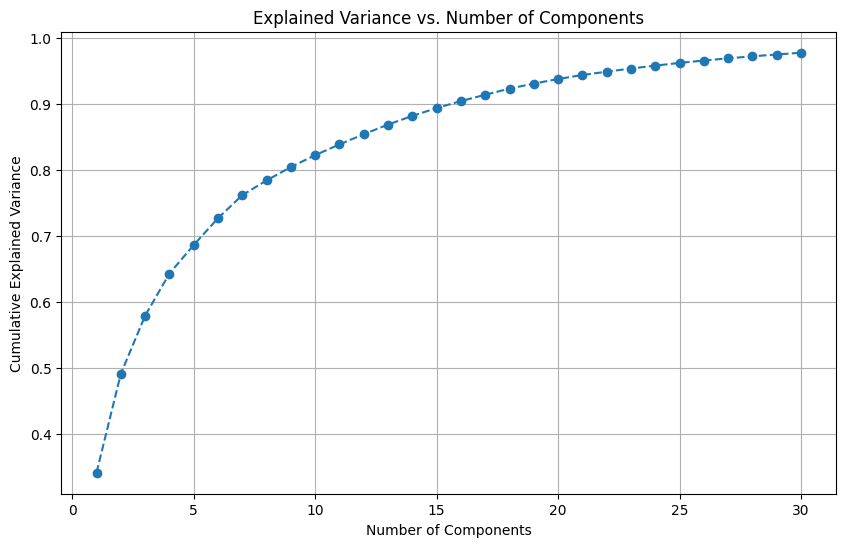

In [62]:
# Creating the principal components
n_components = 30
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [63]:
# Creating the principal components
n_components = 20
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [43]:
# Define the Logistic Regression model
lr = LogisticRegression()

# Parameter distribution
param_distribution = {
    "C": optuna.distributions.FloatDistribution(1e-3, 1e3)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(lr, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Logistic Regression: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Logistic Regression: {optuna_search.best_score_:.4f}")

[I 2024-02-05 19:24:42,629] A new study created in memory with name: no-name-0d8c11a1-c14f-4f5f-b1f6-b3d407f7f761
[I 2024-02-05 19:24:42,727] Trial 0 finished with value: 0.6629233511586452 and parameters: {'C': 4.469360271038055}. Best is trial 0 with value: 0.6629233511586452.
[I 2024-02-05 19:24:42,798] Trial 1 finished with value: 0.6807486631016043 and parameters: {'C': 0.3197562575684278}. Best is trial 1 with value: 0.6807486631016043.
[I 2024-02-05 19:24:42,887] Trial 2 finished with value: 0.6689839572192513 and parameters: {'C': 3.0573324319421755}. Best is trial 1 with value: 0.6807486631016043.
[I 2024-02-05 19:24:42,963] Trial 3 finished with value: 0.6689839572192513 and parameters: {'C': 2.7472221225958604}. Best is trial 1 with value: 0.6807486631016043.
[I 2024-02-05 19:24:43,554] Trial 4 finished with value: 0.6206773618538324 and parameters: {'C': 0.0039537331515699615}. Best is trial 1 with value: 0.6807486631016043.
[I 2024-02-05 19:24:43,629] Trial 5 finished with

Best Parameters for Logistic Regression: {'C': 0.3006523738667214}
Best Mean Accuracy for Logistic Regression: 0.6927


In [44]:
# Define the Random Forest model
model = RandomForestClassifier()

# Parameter distribution
param_distribution = {
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "max_depth": optuna.distributions.IntDistribution(5, 15),
    "min_samples_split": optuna.distributions.IntDistribution(2, 10),
    "min_samples_leaf": optuna.distributions.IntDistribution(1, 4)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Random Forest: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Random Forest: {optuna_search.best_score_:.4f}")

[I 2024-02-05 19:25:20,496] A new study created in memory with name: no-name-6ff07df2-5f89-4902-a5cc-9e8f9c2a2509
[I 2024-02-05 19:25:23,618] Trial 0 finished with value: 0.6746880570409981 and parameters: {'n_estimators': 142, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6746880570409981.
[I 2024-02-05 19:25:26,266] Trial 1 finished with value: 0.6386809269162209 and parameters: {'n_estimators': 131, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6746880570409981.
[I 2024-02-05 19:25:31,975] Trial 2 finished with value: 0.6021390374331551 and parameters: {'n_estimators': 260, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6746880570409981.
[I 2024-02-05 19:25:37,001] Trial 3 finished with value: 0.6504456327985739 and parameters: {'n_estimators': 250, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value

Best Parameters for Random Forest: {'n_estimators': 274, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 4}
Best Mean Accuracy for Random Forest: 0.6866


In [45]:
# Define the XGBClassifier model
model = XGBClassifier()

# Parameter distribution
param_distribution = {
    "booster": optuna.distributions.CategoricalDistribution(['gbtree', 'gblinear']),
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]),
    "max_depth": optuna.distributions.IntDistribution(3, 9)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for XGBClassifier: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for XGBClassifier: {optuna_search.best_score_:.4f}")

[I 2024-02-05 20:10:36,198] A new study created in memory with name: no-name-f77ee73d-a157-4f42-88e3-e47717ea2553
[I 2024-02-05 20:10:36,672] Trial 0 finished with value: 0.6629233511586452 and parameters: {'booster': 'gblinear', 'n_estimators': 446, 'learning_rate': 0.008980626845700364, 'max_depth': 5}. Best is trial 0 with value: 0.6629233511586452.
[I 2024-02-05 20:10:37,024] Trial 1 finished with value: 0.6688057040998217 and parameters: {'booster': 'gblinear', 'n_estimators': 425, 'learning_rate': 0.03556984916948349, 'max_depth': 4}. Best is trial 1 with value: 0.6688057040998217.
[I 2024-02-05 20:10:37,887] Trial 2 finished with value: 0.5483065953654188 and parameters: {'booster': 'gbtree', 'n_estimators': 240, 'learning_rate': 0.06160938991249372, 'max_depth': 3}. Best is trial 1 with value: 0.6688057040998217.
[I 2024-02-05 20:10:38,232] Trial 3 finished with value: 0.6807486631016042 and parameters: {'booster': 'gblinear', 'n_estimators': 389, 'learning_rate': 0.07540609072

Best Parameters for XGBoost: {'booster': 'gblinear', 'n_estimators': 101, 'learning_rate': 0.0024377466330443944, 'max_depth': 8}
Best Mean Accuracy for XGBoost: 0.6930


In [46]:
# Define the LGBMClassifier model
model = LGBMClassifier(verbose=-1)

# Parameter distribution
param_distribution = {
    "boosting_type": optuna.distributions.CategoricalDistribution(['gbdt', 'dart']),
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]),
    "max_depth": optuna.distributions.IntDistribution(3, 9)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for LightGBM: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for LightGBM: {optuna_search.best_score_:.4f}")

[I 2024-02-05 20:13:45,387] A new study created in memory with name: no-name-7c666a74-0971-4d22-8033-51daf0ab727f
[I 2024-02-05 20:13:46,139] Trial 0 finished with value: 0.6085561497326203 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 298, 'learning_rate': 0.021715821095534094, 'max_depth': 9}. Best is trial 0 with value: 0.6085561497326203.
[I 2024-02-05 20:13:46,421] Trial 1 finished with value: 0.5786096256684491 and parameters: {'boosting_type': 'dart', 'n_estimators': 147, 'learning_rate': 0.03496000074166333, 'max_depth': 5}. Best is trial 0 with value: 0.6085561497326203.
[I 2024-02-05 20:13:46,686] Trial 2 finished with value: 0.5422459893048128 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 189, 'learning_rate': 0.0011688096315162922, 'max_depth': 5}. Best is trial 0 with value: 0.6085561497326203.
[I 2024-02-05 20:13:46,920] Trial 3 finished with value: 0.5848484848484847 and parameters: {'boosting_type': 'dart', 'n_estimators': 134, 'learning_rate': 0

Best Parameters for LightGBM: {'boosting_type': 'gbdt', 'n_estimators': 326, 'learning_rate': 0.022410876345211606, 'max_depth': 7}
Best Mean Accuracy for LightGBM: 0.6328


In [47]:
# Define the DecisionTreeClassifier model
model = DecisionTreeClassifier()

# Parameter distribution
param_distribution = {
    "max_depth": optuna.distributions.IntDistribution(3, 9),
    "min_samples_split": optuna.distributions.IntDistribution(2, 10)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Decision Tree: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Decision Tree: {optuna_search.best_score_:.4f}")

[I 2024-02-05 20:16:58,245] A new study created in memory with name: no-name-ba981517-7282-4a98-a624-99a9ca4e6d82
[I 2024-02-05 20:16:58,309] Trial 0 finished with value: 0.5310160427807487 and parameters: {'max_depth': 4, 'min_samples_split': 4}. Best is trial 0 with value: 0.5310160427807487.
[I 2024-02-05 20:16:58,378] Trial 1 finished with value: 0.5663101604278075 and parameters: {'max_depth': 5, 'min_samples_split': 2}. Best is trial 1 with value: 0.5663101604278075.
[I 2024-02-05 20:16:58,481] Trial 2 finished with value: 0.5730837789661318 and parameters: {'max_depth': 6, 'min_samples_split': 4}. Best is trial 2 with value: 0.5730837789661318.
[I 2024-02-05 20:16:58,548] Trial 3 finished with value: 0.5367201426024956 and parameters: {'max_depth': 3, 'min_samples_split': 7}. Best is trial 2 with value: 0.5730837789661318.
[I 2024-02-05 20:16:58,630] Trial 4 finished with value: 0.530837789661319 and parameters: {'max_depth': 5, 'min_samples_split': 3}. Best is trial 2 with valu

Best Parameters for Decision Tree: {'max_depth': 6, 'min_samples_split': 5}
Best Mean Accuracy for Decision Tree: 0.5848


In [48]:
# Define the SVC model
model = SVC()

# Parameter distribution
param_distribution = {
    "C": optuna.distributions.FloatDistribution(1e-3, 1e3),
    "kernel": optuna.distributions.CategoricalDistribution(['linear', 'rbf'])
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for SVM: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for SVM: {optuna_search.best_score_:.4f}")

[I 2024-02-05 20:17:55,085] A new study created in memory with name: no-name-5b620aba-c2d2-42f1-8faa-e31f76a11bf6
[I 2024-02-05 20:17:55,127] Trial 0 finished with value: 0.5240641711229946 and parameters: {'C': 0.02363334449231636, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5240641711229946.
[I 2024-02-05 20:17:55,168] Trial 1 finished with value: 0.5659536541889483 and parameters: {'C': 135.018900249695, 'kernel': 'rbf'}. Best is trial 1 with value: 0.5659536541889483.
[I 2024-02-05 20:17:55,206] Trial 2 finished with value: 0.5240641711229946 and parameters: {'C': 0.008447137050787895, 'kernel': 'rbf'}. Best is trial 1 with value: 0.5659536541889483.
[I 2024-02-05 20:17:55,235] Trial 3 finished with value: 0.6329768270944742 and parameters: {'C': 0.4421757168656107, 'kernel': 'linear'}. Best is trial 3 with value: 0.6329768270944742.
[I 2024-02-05 20:17:55,267] Trial 4 finished with value: 0.5240641711229946 and parameters: {'C': 0.0021283066950596283, 'kernel': 'rbf'}. Best is

Best Parameters for SVM: {'C': 0.09953463217928142, 'kernel': 'linear'}
Best Mean Accuracy for SVM: 0.6927


In [13]:
# Define the AdaBoostClassifier model
model = AdaBoostClassifier()

# Parameter distribution
param_distribution = {
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1])
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for AdaBoostClassifier: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for AdaBoostClassifier: {optuna_search.best_score_:.4f}")

[I 2024-02-06 14:10:25,440] A new study created in memory with name: no-name-0e9cea4d-b805-4830-b01f-7ed98c9854df


[I 2024-02-06 14:10:34,501] Trial 0 finished with value: 0.5361853832442067 and parameters: {'n_estimators': 334, 'learning_rate': 0.0013255384118727813}. Best is trial 0 with value: 0.5361853832442067.
[I 2024-02-06 14:10:40,409] Trial 1 finished with value: 0.5422459893048128 and parameters: {'n_estimators': 249, 'learning_rate': 0.0036619173285968986}. Best is trial 1 with value: 0.5422459893048128.
[I 2024-02-06 14:10:45,074] Trial 2 finished with value: 0.5422459893048128 and parameters: {'n_estimators': 208, 'learning_rate': 0.0011153085549572433}. Best is trial 1 with value: 0.5422459893048128.
[I 2024-02-06 14:10:55,363] Trial 3 finished with value: 0.5848484848484847 and parameters: {'n_estimators': 460, 'learning_rate': 0.0067322262787846195}. Best is trial 3 with value: 0.5848484848484847.
[I 2024-02-06 14:11:02,633] Trial 4 finished with value: 0.5725490196078431 and parameters: {'n_estimators': 308, 'learning_rate': 0.0038267432619999314}. Best is trial 3 with value: 0.584

Best Parameters for AdaBoost: {'n_estimators': 482, 'learning_rate': 0.08736214891704565}
Best Mean Accuracy for AdaBoost: 0.6870


In [26]:
# Storing the best hypertuned parameters for Logistic Regression
lr_best_params = {'C': 0.3006523738667214}
best_pca_lr = LogisticRegression(**lr_best_params)

# Storing the best hypertuned parameters for Random Forest
rf_best_params = {'n_estimators': 274, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 4}
best_pca_rf = RandomForestClassifier(**rf_best_params)

# Storing the best hypertuned parameters for XGBoost
xgb_best_params = {'booster': 'gblinear', 'n_estimators': 101, 'learning_rate': 0.0024377466330443944, 'max_depth': 8}
best_pca_xgb = XGBClassifier(**xgb_best_params)

# Storing the best hypertuned parameters for LightGBM
lgbm_best_params = {'boosting_type': 'gbdt', 'n_estimators': 326, 'learning_rate': 0.022410876345211606, 'max_depth': 7}
best_pca_lgbm = LGBMClassifier(**lgbm_best_params, verbose=-1)

# Storing the best hypertuned parameters for Decision Tree
dt_best_params = {'max_depth': 6, 'min_samples_split': 5}
best_pca_dt = DecisionTreeClassifier(**dt_best_params)

# Storing the best hypertuned parameters for SVM
svm_best_params = {'C': 0.09953463217928142, 'kernel': 'linear'}
best_pca_svm = SVC(**svm_best_params)

# Storing the best hypertuned parameters for AdaBoost
ada_best_params = {'n_estimators': 482, 'learning_rate': 0.08736214891704565}
best_pca_ada = AdaBoostClassifier(**ada_best_params)

In [28]:
# Training all the models with the best parameters
best_pca_lr.fit(X_pca, y_encoded)
best_pca_rf.fit(X_pca, y_encoded)
best_pca_xgb.fit(X_pca, y_encoded)
best_pca_lgbm.fit(X_pca, y_encoded)
best_pca_dt.fit(X_pca, y_encoded)
best_pca_svm.fit(X_pca, y_encoded)
best_pca_ada.fit(X_pca, y_encoded)

print("All hypertuned models (with PCA) trained")

All hypertuned models (with PCA) trained


In [29]:
predictions = best_pca_lr.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
total_samples = len(test_df)
accuracy = correct_predictions / total_samples

print(f'Accuracy of Logistic Regression (with PCA): {accuracy:.4f}')

predictions = best_pca_rf.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Random Forest (with PCA): {accuracy:.4f}')

predictions = best_pca_xgb.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of XGBoost (with PCA): {accuracy:.4f}')

predictions = best_pca_lgbm.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of LightGBM (with PCA): {accuracy:.4f}')

predictions = best_pca_dt.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Decision Tree (with PCA): {accuracy:.4f}')

predictions = best_pca_svm.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of SVM (with PCA): {accuracy:.4f}')

predictions = best_pca_ada.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of AdaBoost (with PCA): {accuracy:.4f}')

Accuracy of Logistic Regression (with PCA): 0.6761
Accuracy of Random Forest (with PCA): 0.5915
Accuracy of XGBoost (with PCA): 0.6479
Accuracy of LightGBM (with PCA): 0.5493
Accuracy of Decision Tree (with PCA): 0.5070
Accuracy of SVM (with PCA): 0.7183
Accuracy of AdaBoost (with PCA): 0.5634


Testing baseline PCA models on the dataset

In [64]:
# Define base models
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42, verbose=-1)
dt = DecisionTreeClassifier(random_state=42)
svm = SVC(random_state=42)
ada = AdaBoostClassifier(random_state=42)

In [65]:
# Training base models on PCA modified dataset
lr.fit(X_pca, y_encoded)
rf.fit(X_pca, y_encoded)
xgb.fit(X_pca, y_encoded)
lgbm.fit(X_pca, y_encoded)
dt.fit(X_pca, y_encoded)
svm.fit(X_pca, y_encoded)
ada.fit(X_pca, y_encoded)

print("All baseline models (with PCA) trained")

All baseline models (with PCA) trained


In [66]:
# Testing the models on test data
predictions = lr.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
total_samples = len(test_df)
accuracy = correct_predictions / total_samples

print(f'Accuracy of Logistic Regression: {accuracy:.4f}')

predictions = rf.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Random Forest: {accuracy:.4f}')

predictions = xgb.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of XGBoost: {accuracy:.4f}')

predictions = lgbm.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of LightGBM: {accuracy:.4f}')

predictions = dt.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Decision Tree: {accuracy:.4f}')

predictions = svm.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of SVM: {accuracy:.4f}')

predictions = ada.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of AdaBoost: {accuracy:.4f}')

Accuracy of Logistic Regression: 0.5775
Accuracy of Random Forest: 0.5915
Accuracy of XGBoost: 0.4930
Accuracy of LightGBM: 0.5775
Accuracy of Decision Tree: 0.5915
Accuracy of SVM: 0.5775
Accuracy of AdaBoost: 0.5352


Performing PCA decomposition on augmented dataset

In [67]:
# Features and Target variable
X_augmented = augmented_df.drop(['adressfname', 'dx', 'mmse'], axis=1)
y_augmented = augmented_df['dx']
X_test = test_df.drop(['adressfname', 'Dx', 'ID'], axis=1)

# Standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_augmented)
X_test_scaled = scaler.transform(X_test)

# Label encoding the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y_augmented)

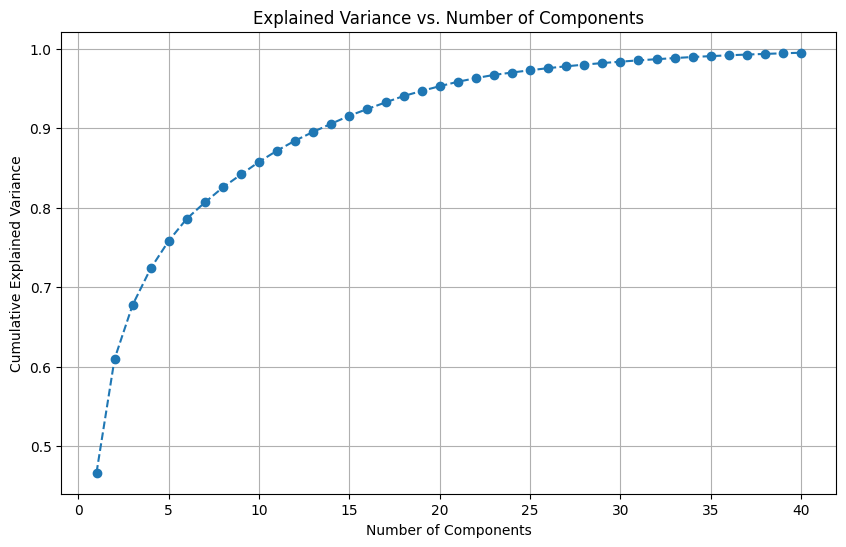

In [70]:
# Creating the principal components
n_components = 40
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [71]:
# Creating the principal components
n_components = 35
pca = PCA(n_components=n_components)
X_augmented_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [75]:
# Define the Logistic Regression model
lr = LogisticRegression()

# Parameter distribution
param_distribution = {
    "C": optuna.distributions.FloatDistribution(1e-3, 1e3)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(lr, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Logistic Regression: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Logistic Regression: {optuna_search.best_score_:.4f}")

[I 2024-03-25 10:28:25,783] A new study created in memory with name: no-name-c29285da-c447-4f08-b82e-4e18d3e3b89f
[I 2024-03-25 10:28:25,970] Trial 0 finished with value: 0.572289156626506 and parameters: {'C': 25.271782671740937}. Best is trial 0 with value: 0.572289156626506.
[I 2024-03-25 10:28:26,292] Trial 1 finished with value: 0.572289156626506 and parameters: {'C': 218.22013395793223}. Best is trial 0 with value: 0.572289156626506.
[I 2024-03-25 10:28:26,450] Trial 2 finished with value: 0.572289156626506 and parameters: {'C': 73.7855176697066}. Best is trial 0 with value: 0.572289156626506.
[I 2024-03-25 10:28:26,593] Trial 3 finished with value: 0.572289156626506 and parameters: {'C': 533.499568527031}. Best is trial 0 with value: 0.572289156626506.
[I 2024-03-25 10:28:26,744] Trial 4 finished with value: 0.572289156626506 and parameters: {'C': 674.3307090433217}. Best is trial 0 with value: 0.572289156626506.
[I 2024-03-25 10:28:26,914] Trial 5 finished with value: 0.5722891

Best Parameters for Logistic Regression: {'C': 0.04786934826357481}
Best Mean Accuracy for Logistic Regression: 0.5771


In [76]:
# Define the Random Forest model
model = RandomForestClassifier()

# Parameter distribution
param_distribution = {
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "max_depth": optuna.distributions.IntDistribution(5, 15),
    "min_samples_split": optuna.distributions.IntDistribution(2, 10),
    "min_samples_leaf": optuna.distributions.IntDistribution(1, 4)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Random Forest: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Random Forest: {optuna_search.best_score_:.4f}")

[I 2024-03-25 10:29:43,673] A new study created in memory with name: no-name-3f830ca6-d8a1-4bf2-b225-624b0421bf88
[I 2024-03-25 10:30:11,990] Trial 0 finished with value: 0.5373493975903615 and parameters: {'n_estimators': 384, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5373493975903615.
[I 2024-03-25 10:30:46,569] Trial 1 finished with value: 0.5421686746987951 and parameters: {'n_estimators': 441, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.5421686746987951.
[I 2024-03-25 10:31:17,453] Trial 2 finished with value: 0.5481927710843374 and parameters: {'n_estimators': 452, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.5481927710843374.
[I 2024-03-25 10:31:27,981] Trial 3 finished with value: 0.5506024096385542 and parameters: {'n_estimators': 151, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value:

Best Parameters for Random Forest: {'n_estimators': 125, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best Mean Accuracy for Random Forest: 0.5747


In [77]:
# Define the XGBClassifier model
model = XGBClassifier()

# Parameter distribution
param_distribution = {
    "booster": optuna.distributions.CategoricalDistribution(['gbtree', 'gblinear']),
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]),
    "max_depth": optuna.distributions.IntDistribution(3, 9)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for XGBClassifier: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for XGBClassifier: {optuna_search.best_score_:.4f}")

[I 2024-03-25 11:59:35,703] A new study created in memory with name: no-name-b9ceb72d-7ba6-4f66-bd5b-8467f0d722f6
[I 2024-03-25 11:59:35,890] Trial 0 finished with value: 0.5602409638554218 and parameters: {'booster': 'gblinear', 'n_estimators': 178, 'learning_rate': 0.02, 'max_depth': 9}. Best is trial 0 with value: 0.5602409638554218.
[I 2024-03-25 11:59:49,105] Trial 1 finished with value: 0.5289156626506024 and parameters: {'booster': 'gbtree', 'n_estimators': 353, 'learning_rate': 0.002, 'max_depth': 9}. Best is trial 0 with value: 0.5602409638554218.
[I 2024-03-25 12:00:00,422] Trial 2 finished with value: 0.5421686746987951 and parameters: {'booster': 'gbtree', 'n_estimators': 335, 'learning_rate': 0.01, 'max_depth': 9}. Best is trial 0 with value: 0.5602409638554218.
[I 2024-03-25 12:00:04,083] Trial 3 finished with value: 0.5650602409638554 and parameters: {'booster': 'gbtree', 'n_estimators': 412, 'learning_rate': 0.005, 'max_depth': 4}. Best is trial 3 with value: 0.56506024

Best Parameters for XGBClassifier: {'booster': 'gblinear', 'n_estimators': 259, 'learning_rate': 0.05, 'max_depth': 3}
Best Mean Accuracy for XGBClassifier: 0.5759


In [78]:
# Define the LGBMClassifier model
model = LGBMClassifier(verbose=-1)

# Parameter distribution
param_distribution = {
    "boosting_type": optuna.distributions.CategoricalDistribution(['gbdt', 'dart']),
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]),
    "max_depth": optuna.distributions.IntDistribution(3, 9)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for LightGBM: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for LightGBM: {optuna_search.best_score_:.4f}")

[I 2024-03-25 12:04:51,802] A new study created in memory with name: no-name-a00a8d05-eb3a-419c-9adc-f559dfcb8d63
[I 2024-03-25 12:04:55,381] Trial 0 finished with value: 0.5566265060240964 and parameters: {'boosting_type': 'dart', 'n_estimators': 327, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 0 with value: 0.5566265060240964.
[I 2024-03-25 12:04:57,639] Trial 1 finished with value: 0.5337349397590361 and parameters: {'boosting_type': 'dart', 'n_estimators': 426, 'learning_rate': 0.02, 'max_depth': 3}. Best is trial 0 with value: 0.5566265060240964.
[I 2024-03-25 12:05:00,578] Trial 2 finished with value: 0.5253012048192771 and parameters: {'boosting_type': 'dart', 'n_estimators': 359, 'learning_rate': 0.01, 'max_depth': 5}. Best is trial 0 with value: 0.5566265060240964.
[I 2024-03-25 12:05:01,661] Trial 3 finished with value: 0.5421686746987951 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 459, 'learning_rate': 0.05, 'max_depth': 4}. Best is trial 0 with value:

Best Parameters for LightGBM: {'boosting_type': 'dart', 'n_estimators': 170, 'learning_rate': 0.1, 'max_depth': 5}
Best Mean Accuracy for LightGBM: 0.5795


In [79]:
# Define the DecisionTreeClassifier model
model = DecisionTreeClassifier()

# Parameter distribution
param_distribution = {
    "max_depth": optuna.distributions.IntDistribution(3, 9),
    "min_samples_split": optuna.distributions.IntDistribution(2, 10)
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for Decision Tree: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for Decision Tree: {optuna_search.best_score_:.4f}")

[I 2024-03-25 12:14:30,244] A new study created in memory with name: no-name-b20ea7fd-d30f-4b35-9ffa-576e3c6d3716
[I 2024-03-25 12:14:30,471] Trial 0 finished with value: 0.5216867469879518 and parameters: {'max_depth': 8, 'min_samples_split': 6}. Best is trial 0 with value: 0.5216867469879518.
[I 2024-03-25 12:14:30,689] Trial 1 finished with value: 0.5120481927710844 and parameters: {'max_depth': 8, 'min_samples_split': 5}. Best is trial 0 with value: 0.5216867469879518.
[I 2024-03-25 12:14:30,908] Trial 2 finished with value: 0.5253012048192771 and parameters: {'max_depth': 9, 'min_samples_split': 8}. Best is trial 2 with value: 0.5253012048192771.
[I 2024-03-25 12:14:31,035] Trial 3 finished with value: 0.508433734939759 and parameters: {'max_depth': 4, 'min_samples_split': 8}. Best is trial 2 with value: 0.5253012048192771.
[I 2024-03-25 12:14:31,251] Trial 4 finished with value: 0.5144578313253012 and parameters: {'max_depth': 8, 'min_samples_split': 2}. Best is trial 2 with valu

Best Parameters for Decision Tree: {'max_depth': 9, 'min_samples_split': 10}
Best Mean Accuracy for Decision Tree: 0.5373


In [80]:
# Define the SVC model
model = SVC()

# Parameter distribution
param_distribution = {
    "C": optuna.distributions.FloatDistribution(1e-3, 1e3),
    "kernel": optuna.distributions.CategoricalDistribution(['linear', 'rbf'])
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for SVM: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for SVM: {optuna_search.best_score_:.4f}")

[I 2024-03-25 12:17:01,715] A new study created in memory with name: no-name-2f31e571-c64e-478a-8305-f146947b03e9
[I 2024-03-25 12:17:01,933] Trial 0 finished with value: 0.6180722891566265 and parameters: {'C': 681.105558931056, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6180722891566265.
[I 2024-03-25 12:17:02,264] Trial 1 finished with value: 0.6180722891566265 and parameters: {'C': 945.4854068033927, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6180722891566265.
[I 2024-03-25 12:20:41,556] Trial 2 finished with value: 0.5554216867469879 and parameters: {'C': 681.8698087867152, 'kernel': 'linear'}. Best is trial 0 with value: 0.6180722891566265.
[I 2024-03-25 12:20:41,695] Trial 3 finished with value: 0.6240963855421687 and parameters: {'C': 88.90089974605856, 'kernel': 'rbf'}. Best is trial 3 with value: 0.6240963855421687.
[I 2024-03-25 12:20:41,822] Trial 4 finished with value: 0.6180722891566265 and parameters: {'C': 567.2287825756009, 'kernel': 'rbf'}. Best is trial 3 w

Best Parameters for SVM: {'C': 49.89592736107169, 'kernel': 'rbf'}
Best Mean Accuracy for SVM: 0.6313


In [81]:
# Define the AdaBoostClassifier model
model = AdaBoostClassifier()

# Parameter distribution
param_distribution = {
    "n_estimators": optuna.distributions.IntDistribution(100, 500),
    "learning_rate": optuna.distributions.CategoricalDistribution([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1])
}

# Create an OptunaSearchCV object
optuna_search = OptunaSearchCV(model, param_distribution, cv=5, n_trials=500)

# Fit the model
optuna_search.fit(X_augmented_pca, y_encoded)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters for AdaBoostClassifier: {optuna_search.best_params_}")
print(f"Best Mean Accuracy for AdaBoostClassifier: {optuna_search.best_score_:.4f}")

[I 2024-03-25 12:57:51,154] A new study created in memory with name: no-name-2ef33129-f76e-491f-a23f-0fb26687b01f
[I 2024-03-25 12:58:15,050] Trial 0 finished with value: 0.536144578313253 and parameters: {'n_estimators': 360, 'learning_rate': 0.01}. Best is trial 0 with value: 0.536144578313253.
[I 2024-03-25 12:58:25,506] Trial 1 finished with value: 0.5373493975903614 and parameters: {'n_estimators': 150, 'learning_rate': 0.05}. Best is trial 1 with value: 0.5373493975903614.
[I 2024-03-25 12:58:57,075] Trial 2 finished with value: 0.5301204819277109 and parameters: {'n_estimators': 477, 'learning_rate': 0.002}. Best is trial 1 with value: 0.5373493975903614.
[I 2024-03-25 12:59:26,266] Trial 3 finished with value: 0.5337349397590361 and parameters: {'n_estimators': 440, 'learning_rate': 0.002}. Best is trial 1 with value: 0.5373493975903614.
[I 2024-03-25 12:59:33,440] Trial 4 finished with value: 0.4554216867469879 and parameters: {'n_estimators': 109, 'learning_rate': 0.001}. Bes

Best Parameters for AdaBoostClassifier: {'n_estimators': 259, 'learning_rate': 0.01}
Best Mean Accuracy for AdaBoostClassifier: 0.5518


In [ ]:
# Storing the best hypertuned parameters for Logistic Regression
lr_best_params = {}
best_pca_lr = LogisticRegression(**lr_best_params)

# Storing the best hypertuned parameters for Random Forest
rf_best_params = {}
best_pca_rf = RandomForestClassifier(**rf_best_params)

# Storing the best hypertuned parameters for XGBoost
xgb_best_params = {}
best_pca_xgb = XGBClassifier(**xgb_best_params)

# Storing the best hypertuned parameters for LightGBM
lgbm_best_params = {}
best_pca_lgbm = LGBMClassifier(**lgbm_best_params, verbose=-1)

# Storing the best hypertuned parameters for Decision Tree
dt_best_params = {}
best_pca_dt = DecisionTreeClassifier(**dt_best_params)

# Storing the best hypertuned parameters for SVM
svm_best_params = {}
best_pca_svm = SVC(**svm_best_params)

# Storing the best hypertuned parameters for AdaBoost
ada_best_params = {}
best_pca_ada = AdaBoostClassifier(**ada_best_params)

In [ ]:
# Training all the models with the best parameters
best_pca_lr.fit(X_augmented_pca, y_encoded)
best_pca_rf.fit(X_augmented_pca, y_encoded)
best_pca_xgb.fit(X_augmented_pca, y_encoded)
best_pca_lgbm.fit(X_augmented_pca, y_encoded)
best_pca_dt.fit(X_augmented_pca, y_encoded)
best_pca_svm.fit(X_augmented_pca, y_encoded)
best_pca_ada.fit(X_augmented_pca, y_encoded)

print("All hypertuned models (with PCA) trained on augmented dataset")

In [ ]:
# Testing the models on test data
predictions = lr.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
total_samples = len(test_df)
accuracy = correct_predictions / total_samples

print(f'Accuracy of Logistic Regression: {accuracy:.4f}')

predictions = rf.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Random Forest: {accuracy:.4f}')

predictions = xgb.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of XGBoost: {accuracy:.4f}')

predictions = lgbm.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of LightGBM: {accuracy:.4f}')

predictions = dt.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Decision Tree: {accuracy:.4f}')

predictions = svm.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of SVM: {accuracy:.4f}')

predictions = ada.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of AdaBoost: {accuracy:.4f}')

Testing baseline PCA models trained on augmented dataset

In [72]:
# Define base models
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42, verbose=-1)
dt = DecisionTreeClassifier(random_state=42)
svm = SVC(random_state=42)
ada = AdaBoostClassifier(random_state=42)

In [73]:
# Training base models on PCA modified dataset
lr.fit(X_augmented_pca, y_encoded)
rf.fit(X_augmented_pca, y_encoded)
xgb.fit(X_augmented_pca, y_encoded)
lgbm.fit(X_augmented_pca, y_encoded)
dt.fit(X_augmented_pca, y_encoded)
svm.fit(X_augmented_pca, y_encoded)
ada.fit(X_augmented_pca, y_encoded)

print("All baseline models (with PCA) trained on augmented dataset")

All baseline models (with PCA) trained on augmented dataset


In [74]:
# Testing the models on test data
predictions = lr.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
total_samples = len(test_df)
accuracy = correct_predictions / total_samples

print(f'Accuracy of Logistic Regression: {accuracy:.4f}')

predictions = rf.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Random Forest: {accuracy:.4f}')

predictions = xgb.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of XGBoost: {accuracy:.4f}')

predictions = lgbm.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of LightGBM: {accuracy:.4f}')

predictions = dt.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Decision Tree: {accuracy:.4f}')

predictions = svm.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of SVM: {accuracy:.4f}')

predictions = ada.predict(X_test_pca)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of AdaBoost: {accuracy:.4f}')

Accuracy of Logistic Regression: 0.6197
Accuracy of Random Forest: 0.5915
Accuracy of XGBoost: 0.6620
Accuracy of LightGBM: 0.5915
Accuracy of Decision Tree: 0.6056
Accuracy of SVM: 0.5493
Accuracy of AdaBoost: 0.5493


#### Training models using the Acoustic Embedded features generated using OpenL3

In [5]:
# features_df = pd.read_csv(train_openl3)
# dx_df = pd.read_csv(train_mmse, usecols=['adressfname', 'dx', 'mmse'])

# # merging the two dataframes on adressfname
# df = pd.merge(features_df, dx_df, on='adressfname')
# df.to_csv(os.path.join(os.environ.get("TRAIN"), 'adresso-openl3-pca-embeddings-train.csv'), index=False)

In [4]:
df = pd.read_csv(train_openl3)
df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,adressfname,mmse,dx
0,-27.350261,-11.547916,3.194821,3.233408,23.539571,23.975362,4.950868,19.616343,-5.034369,5.414441,...,0.006380,2.145519,0.188495,-0.701952,0.458338,1.706684,-0.544045,adrso024,20,ad
1,66.056891,-25.791742,3.862756,13.576992,0.404364,-17.442802,6.924843,44.695537,15.976963,8.786722,...,4.415965,-1.993021,3.262250,0.641830,-1.924304,-2.830352,0.520572,adrso025,11,ad
2,105.815696,-31.557052,-24.936550,17.809282,4.960485,1.856382,-1.160028,-12.552959,-7.260625,-8.934382,...,-2.263594,1.143174,-1.712436,2.534207,-0.801921,1.921143,-1.414975,adrso027,18,ad
3,89.408783,-22.635065,-16.626816,16.535224,8.251938,2.577151,5.088128,-8.306204,5.039446,-6.209638,...,2.484383,3.670945,0.333947,-1.309709,-0.535859,-3.206473,2.051542,adrso028,18,ad
4,81.721634,-30.463799,-24.435702,4.301633,4.869426,-22.117550,2.341473,1.638639,-2.461775,9.294784,...,3.921126,-0.848957,-0.916502,-2.012388,0.506803,-3.522666,-1.228324,adrso031,26,ad


In [5]:
df.describe()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,mmse
count,1.660000e+02,1.660000e+02,166.000000,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,...,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,1.660000e+02,166.000000
mean,-6.848605e-16,4.280378e-16,0.000000,6.848605e-16,-3.424302e-16,-5.136454e-16,-1.712151e-16,4.280378e-16,4.280378e-17,1.712151e-16,...,-6.420567e-17,-8.594196e-17,7.490661e-17,9.095803e-17,5.350472e-17,-1.070094e-17,3.210283e-17,-1.070094e-16,6.420567e-17,22.933735
std,4.863126e+01,2.973209e+01,20.399540,1.861016e+01,1.503397e+01,1.383644e+01,1.306868e+01,1.198579e+01,1.086039e+01,1.001257e+01,...,1.965021e+00,1.947264e+00,1.926635e+00,1.859652e+00,1.818334e+00,1.804076e+00,1.782792e+00,1.759631e+00,1.700087e+00,6.992754
min,-6.244162e+01,-8.926828e+01,-39.134347,-4.159396e+01,-3.693640e+01,-3.375086e+01,-3.740478e+01,-2.502728e+01,-2.552499e+01,-3.280089e+01,...,-5.376204e+00,-4.273764e+00,-5.608203e+00,-4.573999e+00,-4.700680e+00,-4.421328e+00,-4.673632e+00,-4.695925e+00,-4.695673e+00,3.000000
25%,-4.224997e+01,-2.221557e+01,-12.138387,-1.145057e+01,-8.936111e+00,-9.018627e+00,-8.131228e+00,-7.269030e+00,-8.176673e+00,-5.127833e+00,...,-1.206372e+00,-1.351278e+00,-1.264054e+00,-1.145340e+00,-1.238148e+00,-1.284641e+00,-1.143548e+00,-1.164350e+00,-1.103267e+00,17.250000
50%,-1.338151e+01,-2.055809e+00,-3.104616,-2.021239e-01,-7.985774e-01,-4.811982e-01,3.527178e-01,-1.698279e+00,-1.140386e+00,2.148636e-01,...,2.191845e-02,-1.364382e-01,-8.824675e-02,-9.577397e-02,-5.885148e-02,-5.058529e-02,-3.513555e-02,7.380923e-02,-2.247940e-02,26.000000
75%,3.202614e+01,2.060075e+01,4.445065,1.367875e+01,6.541963e+00,7.188765e+00,5.851366e+00,5.512751e+00,7.092039e+00,5.995846e+00,...,1.055490e+00,1.275105e+00,1.211240e+00,1.199156e+00,1.093430e+00,1.177880e+00,1.141685e+00,1.181167e+00,1.033709e+00,29.000000
max,1.120975e+02,1.067370e+02,68.401698,4.692621e+01,9.173787e+01,6.083103e+01,4.330240e+01,4.469554e+01,3.395461e+01,3.380586e+01,...,6.278620e+00,5.350636e+00,5.943162e+00,6.978701e+00,4.917930e+00,5.237248e+00,5.596665e+00,5.148685e+00,6.403175e+00,30.000000


In [6]:
# Features and categorical target variable
X = df.drop(['adressfname', 'dx', 'mmse'], axis=1)
y = df['dx']

In [7]:
# Label encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [8]:
def evaluate_model(model_name, model, skf, X, y):

    print(f'\nTraining {model_name}:')
    print('============================')

    # Storing all fold accuracy scores
    accuracy_scores = []
    
    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the classifier on the training data
        model.fit(X_train, y_train)

        # Predict on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model on the test data
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        print(f'Fold {fold}: Accuracy: {accuracy}')
    
    # Calculate the mean accuracy score across all folds
    mean_accuracy = np.mean(accuracy_scores)
    print(f'\nMean Accuracy: {mean_accuracy}')

    print('============================')

In [9]:
# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

In [10]:
# Stratified K-Fold Cross-Validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the baseline model for each classifier
for model_name in classifiers.keys():
    evaluate_model(model_name, classifiers[model_name], stratified_kfold, X, y_encoded)


Training Logistic Regression:
Fold 1: Accuracy: 0.6176470588235294
Fold 2: Accuracy: 0.6060606060606061
Fold 3: Accuracy: 0.7878787878787878
Fold 4: Accuracy: 0.5757575757575758
Fold 5: Accuracy: 0.6060606060606061

Mean Accuracy: 0.638680926916221

Training Random Forest:
Fold 1: Accuracy: 0.5882352941176471
Fold 2: Accuracy: 0.5757575757575758
Fold 3: Accuracy: 0.696969696969697
Fold 4: Accuracy: 0.5757575757575758
Fold 5: Accuracy: 0.48484848484848486

Mean Accuracy: 0.5843137254901961

Training XGBoost:
Fold 1: Accuracy: 0.5588235294117647
Fold 2: Accuracy: 0.6363636363636364
Fold 3: Accuracy: 0.6060606060606061
Fold 4: Accuracy: 0.5757575757575758
Fold 5: Accuracy: 0.6666666666666666

Mean Accuracy: 0.6087344028520498

Training LightGBM:
Fold 1: Accuracy: 0.5294117647058824
Fold 2: Accuracy: 0.3939393939393939
Fold 3: Accuracy: 0.6666666666666666
Fold 4: Accuracy: 0.5757575757575758
Fold 5: Accuracy: 0.6363636363636364

Mean Accuracy: 0.5604278074866309

Training Decision Tree:
F

In [13]:
def objective_lr(trial):
    
    model = LogisticRegression(
        C=trial.suggest_loguniform('C', 1e-3, 1e3)
    )

    # Perform 5-fold stratified cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in stratified_kfold.split(X, y_encoded):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Fit the model on the training fold
        model.fit(X_train, y_train)

        # Predict on the validation fold
        y_pred = model.predict(X_test)

        # Calculate accuracy and store it
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Return the mean accuracy as the objective value for optimization
    return np.mean(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective_lr, n_trials=500)

# Print the best parameters and corresponding accuracy for each model
best_params = study.best_params
best_accuracy = study.best_value
print(f"Best Parameters for Logistic Regression: {best_params}")
print(f"Best Mean Accuracy for Logistic Regression: {best_accuracy:.4f}")

[I 2024-03-02 12:40:42,925] A new study created in memory with name: no-name-11e3336e-143b-4d4a-bba5-84a416ac9bc2


[I 2024-03-02 12:40:43,122] Trial 0 finished with value: 0.6500891265597147 and parameters: {'C': 0.1956384492224648}. Best is trial 0 with value: 0.6500891265597147.
[I 2024-03-02 12:40:43,260] Trial 1 finished with value: 0.6559714795008912 and parameters: {'C': 0.06192200114373407}. Best is trial 1 with value: 0.6559714795008912.
[I 2024-03-02 12:40:43,392] Trial 2 finished with value: 0.6862745098039216 and parameters: {'C': 0.022834677509886953}. Best is trial 2 with value: 0.6862745098039216.
[I 2024-03-02 12:40:43,509] Trial 3 finished with value: 0.6680926916221034 and parameters: {'C': 0.01341535001802621}. Best is trial 2 with value: 0.6862745098039216.
[I 2024-03-02 12:40:43,635] Trial 4 finished with value: 0.65650623885918 and parameters: {'C': 132.32324489695856}. Best is trial 2 with value: 0.6862745098039216.
[I 2024-03-02 12:40:43,772] Trial 5 finished with value: 0.6802139037433155 and parameters: {'C': 0.022122388112320365}. Best is trial 2 with value: 0.686274509803

Best Parameters for Logistic Regression: {'C': 0.022834677509886953}
Best Mean Accuracy for Logistic Regression: 0.6863


In [14]:
def objective_rf(trial):
    
    model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 100, 500),
            max_depth=trial.suggest_int('max_depth', 5, 15),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 4)
        )

    # Perform 5-fold stratified cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in stratified_kfold.split(X, y_encoded):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Fit the model on the training fold
        model.fit(X_train, y_train)

        # Predict on the validation fold
        y_pred = model.predict(X_test)

        # Calculate accuracy and store it
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Return the mean accuracy as the objective value for optimization
    return np.mean(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=500)

# Print the best parameters and corresponding accuracy for each model
best_params = study.best_params
best_accuracy = study.best_value
print(f"Best Parameters for Random Forest: {best_params}")
print(f"Best Mean Accuracy for Random Forest: {best_accuracy:.4f}")

[I 2024-03-02 12:41:46,474] A new study created in memory with name: no-name-5723e0d8-f7fa-4a8a-ac87-78cf6530c3f3
[I 2024-03-02 12:41:51,176] Trial 0 finished with value: 0.5661319073083779 and parameters: {'n_estimators': 346, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5661319073083779.
[I 2024-03-02 12:41:56,235] Trial 1 finished with value: 0.6085561497326203 and parameters: {'n_estimators': 290, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.6085561497326203.
[I 2024-03-02 12:41:59,250] Trial 2 finished with value: 0.57825311942959 and parameters: {'n_estimators': 205, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.6085561497326203.
[I 2024-03-02 12:42:01,265] Trial 3 finished with value: 0.5721925133689839 and parameters: {'n_estimators': 131, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 

Best Parameters for Random Forest: {'n_estimators': 368, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 1}
Best Mean Accuracy for Random Forest: 0.6624


In [15]:
def objective_xgb(trial):
    
    model = XGBClassifier(
            booster=trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
            n_estimators=trial.suggest_int('n_estimators', 100, 500),
            learning_rate=trial.suggest_categorical('learning_rate', [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]),
            max_depth=trial.suggest_int('max_depth', 3, 9)
        )

    # Perform 5-fold stratified cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in stratified_kfold.split(X, y_encoded):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Fit the model on the training fold
        model.fit(X_train, y_train)

        # Predict on the validation fold
        y_pred = model.predict(X_test)

        # Calculate accuracy and store it
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Return the mean accuracy as the objective value for optimization
    return np.mean(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=500)

# Print the best parameters and corresponding accuracy for each model
best_params = study.best_params
best_accuracy = study.best_value
print(f"Best Parameters for XGBoost: {best_params}")
print(f"Best Mean Accuracy for XGBoost: {best_accuracy:.4f}")

[I 2024-03-02 13:56:16,722] A new study created in memory with name: no-name-42aaf632-3875-40e1-93cd-3fb4be792017


[I 2024-03-02 13:56:17,384] Trial 0 finished with value: 0.6322638146167557 and parameters: {'booster': 'gblinear', 'n_estimators': 484, 'learning_rate': 0.005, 'max_depth': 7}. Best is trial 0 with value: 0.6322638146167557.
[I 2024-03-02 13:56:23,235] Trial 1 finished with value: 0.590017825311943 and parameters: {'booster': 'gbtree', 'n_estimators': 353, 'learning_rate': 0.005, 'max_depth': 6}. Best is trial 0 with value: 0.6322638146167557.
[I 2024-03-02 13:56:23,424] Trial 2 finished with value: 0.6204991087344028 and parameters: {'booster': 'gblinear', 'n_estimators': 127, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 0.6322638146167557.
[I 2024-03-02 13:56:23,641] Trial 3 finished with value: 0.6623885918003565 and parameters: {'booster': 'gblinear', 'n_estimators': 176, 'learning_rate': 0.005, 'max_depth': 9}. Best is trial 3 with value: 0.6623885918003565.
[I 2024-03-02 13:56:23,866] Trial 4 finished with value: 0.6024955436720142 and parameters: {'booste

Best Parameters for XGBoost: {'booster': 'gblinear', 'n_estimators': 253, 'learning_rate': 0.005, 'max_depth': 7}
Best Mean Accuracy for XGBoost: 0.6626


In [16]:
def objective_lgbm(trial):
    
    model = LGBMClassifier(
            boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            n_estimators=trial.suggest_int('n_estimators', 100, 500),
            learning_rate=trial.suggest_categorical('learning_rate', [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]),
            max_depth=trial.suggest_int('max_depth', 3, 9),
            verbose=-1
        )

    # Perform 5-fold stratified cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in stratified_kfold.split(X, y_encoded):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Fit the model on the training fold
        model.fit(X_train, y_train)

        # Predict on the validation fold
        y_pred = model.predict(X_test)

        # Calculate accuracy and store it
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Return the mean accuracy as the objective value for optimization
    return np.mean(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm, n_trials=500)

# Print the best parameters and corresponding accuracy for each model
best_params = study.best_params
best_accuracy = study.best_value
print(f"Best Parameters for LightGBM: {best_params}")
print(f"Best Mean Accuracy for LightGBM: {best_accuracy:.4f}")

[I 2024-03-02 14:01:16,443] A new study created in memory with name: no-name-28387509-ab5c-4059-9bc1-c32554c5492c


[I 2024-03-02 14:01:17,146] Trial 0 finished with value: 0.5290552584670232 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 360, 'learning_rate': 0.001, 'max_depth': 8}. Best is trial 0 with value: 0.5290552584670232.
[I 2024-03-02 14:01:17,841] Trial 1 finished with value: 0.5837789661319073 and parameters: {'boosting_type': 'dart', 'n_estimators': 209, 'learning_rate': 0.005, 'max_depth': 6}. Best is trial 1 with value: 0.5837789661319073.
[I 2024-03-02 14:01:18,993] Trial 2 finished with value: 0.6203208556149732 and parameters: {'boosting_type': 'dart', 'n_estimators': 370, 'learning_rate': 0.5, 'max_depth': 9}. Best is trial 2 with value: 0.6203208556149732.
[I 2024-03-02 14:01:19,500] Trial 3 finished with value: 0.5536541889483065 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 191, 'learning_rate': 0.001, 'max_depth': 6}. Best is trial 2 with value: 0.6203208556149732.
[I 2024-03-02 14:01:20,294] Trial 4 finished with value: 0.5661319073083779 and parameters

Best Parameters for LightGBM: {'boosting_type': 'dart', 'n_estimators': 327, 'learning_rate': 0.1, 'max_depth': 7}
Best Mean Accuracy for LightGBM: 0.6328


In [17]:
def objective_dt(trial):
    
    model = DecisionTreeClassifier(
            max_depth=trial.suggest_int('max_depth', 3, 9),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10)
        )

    # Perform 5-fold stratified cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in stratified_kfold.split(X, y_encoded):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Fit the model on the training fold
        model.fit(X_train, y_train)

        # Predict on the validation fold
        y_pred = model.predict(X_test)

        # Calculate accuracy and store it
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Return the mean accuracy as the objective value for optimization
    return np.mean(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=500)

# Print the best parameters and corresponding accuracy for each model
best_params = study.best_params
best_accuracy = study.best_value
print(f"Best Parameters for Decision Tree: {best_params}")
print(f"Best Mean Accuracy for Decision Tree: {best_accuracy:.4f}")

[I 2024-03-02 14:10:44,928] A new study created in memory with name: no-name-b9f73d8a-5d16-4f2b-8f17-d079ff7086fd
[I 2024-03-02 14:10:45,092] Trial 0 finished with value: 0.5055258467023174 and parameters: {'max_depth': 3, 'min_samples_split': 2}. Best is trial 0 with value: 0.5055258467023174.
[I 2024-03-02 14:10:45,271] Trial 1 finished with value: 0.5725490196078431 and parameters: {'max_depth': 9, 'min_samples_split': 5}. Best is trial 1 with value: 0.5725490196078431.
[I 2024-03-02 14:10:45,440] Trial 2 finished with value: 0.5303030303030303 and parameters: {'max_depth': 7, 'min_samples_split': 6}. Best is trial 1 with value: 0.5725490196078431.
[I 2024-03-02 14:10:45,572] Trial 3 finished with value: 0.48770053475935826 and parameters: {'max_depth': 4, 'min_samples_split': 6}. Best is trial 1 with value: 0.5725490196078431.
[I 2024-03-02 14:10:45,694] Trial 4 finished with value: 0.49376114081996436 and parameters: {'max_depth': 4, 'min_samples_split': 8}. Best is trial 1 with v

Best Parameters for Decision Tree: {'max_depth': 9, 'min_samples_split': 2}
Best Mean Accuracy for Decision Tree: 0.6144


In [18]:
def objective_svm(trial):
    
    model = SVC(
            C=trial.suggest_loguniform('C', 1e-3, 1e3),
            kernel=trial.suggest_categorical('kernel', ['linear', 'rbf'])
        )

    # Perform 5-fold stratified cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in stratified_kfold.split(X, y_encoded):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Fit the model on the training fold
        model.fit(X_train, y_train)

        # Predict on the validation fold
        y_pred = model.predict(X_test)

        # Calculate accuracy and store it
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Return the mean accuracy as the objective value for optimization
    return np.mean(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective_svm, n_trials=500)

# Print the best parameters and corresponding accuracy for each model
best_params = study.best_params
best_accuracy = study.best_value
print(f"Best Parameters for SVM: {best_params}")
print(f"Best Mean Accuracy for SVM: {best_accuracy:.4f}")

[I 2024-03-02 14:12:35,768] A new study created in memory with name: no-name-2b528eb5-5e5d-4166-9b69-35306cfe8a70
[I 2024-03-02 14:12:35,811] Trial 0 finished with value: 0.5240641711229946 and parameters: {'C': 0.01516374222246788, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5240641711229946.


[I 2024-03-02 14:12:35,883] Trial 1 finished with value: 0.6800356506238858 and parameters: {'C': 0.012168842433618097, 'kernel': 'linear'}. Best is trial 1 with value: 0.6800356506238858.
[I 2024-03-02 14:12:36,252] Trial 2 finished with value: 0.6445632798573975 and parameters: {'C': 1.38907330674187, 'kernel': 'linear'}. Best is trial 1 with value: 0.6800356506238858.
[I 2024-03-02 14:12:36,591] Trial 3 finished with value: 0.6445632798573975 and parameters: {'C': 61.148425484850556, 'kernel': 'linear'}. Best is trial 1 with value: 0.6800356506238858.
[I 2024-03-02 14:12:36,652] Trial 4 finished with value: 0.6680926916221033 and parameters: {'C': 0.007968785461138052, 'kernel': 'linear'}. Best is trial 1 with value: 0.6800356506238858.
[I 2024-03-02 14:12:36,706] Trial 5 finished with value: 0.6024955436720142 and parameters: {'C': 21.41571185855447, 'kernel': 'rbf'}. Best is trial 1 with value: 0.6800356506238858.
[I 2024-03-02 14:12:36,750] Trial 6 finished with value: 0.63850267

Best Parameters for SVM: {'C': 0.009644216967990157, 'kernel': 'linear'}
Best Mean Accuracy for SVM: 0.6982


In [11]:
def objective_ada(trial):
    
    model = AdaBoostClassifier(
            n_estimators=trial.suggest_int('n_estimators', 100, 500),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
        )

    # Perform 5-fold stratified cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in stratified_kfold.split(X, y_encoded):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Fit the model on the training fold
        model.fit(X_train, y_train)

        # Predict on the validation fold
        y_pred = model.predict(X_test)

        # Calculate accuracy and store it
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Return the mean accuracy as the objective value for optimization
    return np.mean(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective_ada, n_trials=500)

# Print the best parameters and corresponding accuracy for each model
best_params = study.best_params
best_accuracy = study.best_value
print(f"Best Parameters for AdaBoost: {best_params}")
print(f"Best Mean Accuracy for AdaBoost: {best_accuracy:.4f}")

[I 2024-03-02 18:35:37,930] A new study created in memory with name: no-name-6ed8c93f-44bb-4fda-a5f8-59d1e55765cd
[I 2024-03-02 18:35:49,262] Trial 0 finished with value: 0.6081996434937611 and parameters: {'n_estimators': 339, 'learning_rate': 0.04852422510685565}. Best is trial 0 with value: 0.6081996434937611.
[I 2024-03-02 18:35:52,826] Trial 1 finished with value: 0.5844919786096257 and parameters: {'n_estimators': 109, 'learning_rate': 0.06163360742363223}. Best is trial 0 with value: 0.6081996434937611.
[I 2024-03-02 18:35:56,437] Trial 2 finished with value: 0.6081996434937611 and parameters: {'n_estimators': 113, 'learning_rate': 0.013086199369367512}. Best is trial 0 with value: 0.6081996434937611.
[I 2024-03-02 18:36:08,179] Trial 3 finished with value: 0.566488413547237 and parameters: {'n_estimators': 380, 'learning_rate': 0.009144233683699918}. Best is trial 0 with value: 0.6081996434937611.
[I 2024-03-02 18:36:15,575] Trial 4 finished with value: 0.6144385026737967 and p

Best Parameters for AdaBoost: {'n_estimators': 195, 'learning_rate': 0.09765195480258079}
Best Mean Accuracy for AdaBoost: 0.6264


In [8]:
# Storing the best hypertuned parameters for Logistic Regression
lr_best_params = {'C': 0.022834677509886953}
best_lr = LogisticRegression(**lr_best_params)

# Storing the best hypertuned parameters for Random Forest
rf_best_params = {'n_estimators': 368, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 1}
best_rf = RandomForestClassifier(**rf_best_params)

# Storing the best hypertuned parameters for XGBoost
xgb_best_params = {'booster': 'gblinear', 'n_estimators': 253, 'learning_rate': 0.005, 'max_depth': 7}
best_xgb = XGBClassifier(**xgb_best_params)

# Storing the best hypertuned parameters for LightGBM
lgbm_best_params = {'boosting_type': 'dart', 'n_estimators': 327, 'learning_rate': 0.1, 'max_depth': 7}
best_lgbm = LGBMClassifier(**lgbm_best_params, verbose=-1)

# Storing the best hypertuned parameters for Decision Tree
dt_best_params = {'max_depth': 9, 'min_samples_split': 2}
best_dt = DecisionTreeClassifier(**dt_best_params)

# Storing the best hypertuned parameters for SVM
svm_best_params = {'C': 0.009644216967990157, 'kernel': 'linear'}
best_svm = SVC(**svm_best_params)

# Storing the best hypertuned parameters for AdaBoost
ada_best_params = {'n_estimators': 195, 'learning_rate': 0.09765195480258079}
best_ada = AdaBoostClassifier(**ada_best_params)

In [9]:
# Training all the models with best parameters
best_lr.fit(X, y_encoded)
best_rf.fit(X, y_encoded)
best_xgb.fit(X, y_encoded)
best_lgbm.fit(X, y_encoded)
best_dt.fit(X, y_encoded)
best_svm.fit(X, y_encoded)
best_ada.fit(X, y_encoded)

print("All hypertuned classification models trained")

All hypertuned classification models trained


In [12]:
test_df = pd.read_csv(test_openl3)
ground_truth_df = pd.read_csv(truth_task1)

# Map values in 'Dx' column to 'cn' and 'ad' -> TESTING Purposes
ground_truth_df['Dx'] = ground_truth_df['Dx'].map({'Control': 'cn', 'ProbableAD': 'ad'})

# Merging the test features with the ground truth
test_df = pd.merge(test_df, ground_truth_df, left_on='adressfname', right_on='ID')

X_test = test_df.drop(['adressfname', 'Dx', 'ID'], axis=1)

In [13]:
# Predictions and accuracy for Logistic Regression model
predictions = best_lr.predict(X_test)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
total_samples = len(test_df)
accuracy = correct_predictions / total_samples

print(f'Accuracy of Logistic Regression (with OpenL3 features): {accuracy:.4f}')

# Predictions and accuracy for Random Forest model
predictions = best_rf.predict(X_test)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Random Forest (with OpenL3 features): {accuracy:.4f}')

# Predictions and accuracy for XGBoost model
predictions = best_xgb.predict(X_test)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of XGBoost (with OpenL3 features): {accuracy:.4f}')

# Predictions and accuracy for LightGBM model
predictions = best_lgbm.predict(X_test)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of LightGBM (with OpenL3 features): {accuracy:.4f}')

# Predictions and accuracy for Decision Tree model
predictions = best_dt.predict(X_test)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of Decision Tree (with OpenL3 features): {accuracy:.4f}')

# Predictions and accuracy for SVM model
predictions = best_svm.predict(X_test)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of SVM (with OpenL3 features): {accuracy:.4f}')

# Predictions and accuracy for AdaBoost model
predictions = best_ada.predict(X_test)
predictions_decoded = le.inverse_transform(predictions)
correct_predictions = (predictions_decoded == test_df['Dx']).sum()
accuracy = correct_predictions / total_samples

print(f'Accuracy of AdaBoost (with OpenL3 features): {accuracy:.4f}')

Accuracy of Logistic Regression (with OpenL3 features): 0.4930
Accuracy of Random Forest (with OpenL3 features): 0.4648
Accuracy of XGBoost (with OpenL3 features): 0.5352
Accuracy of LightGBM (with OpenL3 features): 0.5493
Accuracy of Decision Tree (with OpenL3 features): 0.5070
Accuracy of SVM (with OpenL3 features): 0.4930
Accuracy of AdaBoost (with OpenL3 features): 0.5352
